



[Time split] train_len=170, val_len=30, test_len=51
[Pairs] train=14365 | val=5070 | test=SKIP
[Gap range] min=1 max=169 | val_cross=True | test_pairs=False
✅ Saved run meta: data/resnetdz1111_best1_meta.npz
✅ Saved config snapshot: data/resnetdz1111_best1_config.json
✅ Saved run meta: data/resnetdz1111_final1_meta.npz
✅ Saved config snapshot: data/resnetdz1111_final1_config.json
✅ Warm-start LV prior with empirical (r, A).
Epoch 0001 | loss=636.481861 | val_loss=467.055472 | distortion=630.096422 | val_distortion=460.670033
Epoch 1: val_loss improved from inf to 467.05547, saving model to data\resnetdz1111_best1.h5
Epoch 0002 | loss=348.677872 | val_loss=293.604079 | distortion=342.292433 | val_distortion=287.218640
Epoch 2: val_loss improved from 467.05547 to 293.60408, saving model to data\resnetdz1111_best1.h5
Epoch 0003 | loss=205.442842 | val_loss=150.963310 | distortion=199.057403 | val_distortion=144.577871
Epoch 3: val_loss improved from 293.60408 to 150.96331, saving mode

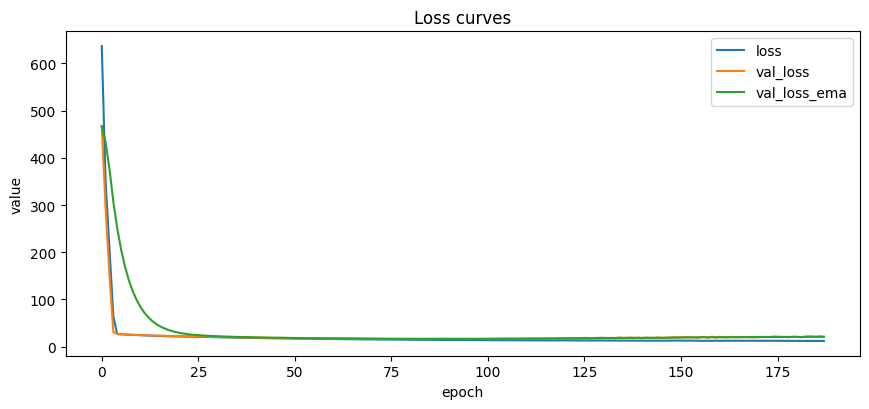

🖼 saved: out_pdf_like/plots\curve_loss.png


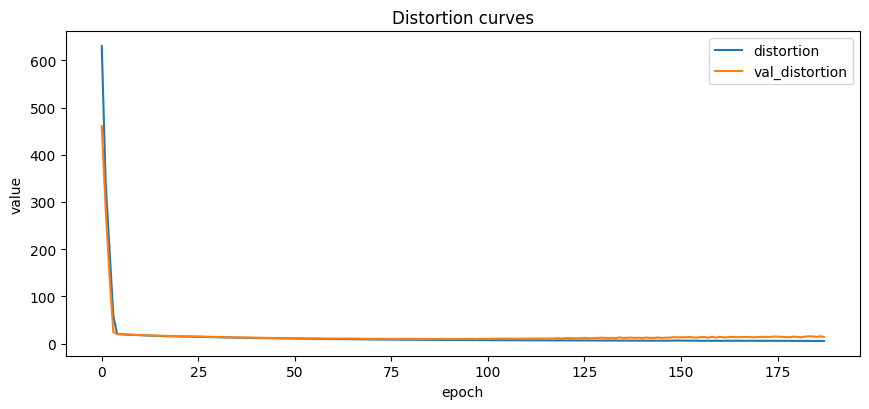

🖼 saved: out_pdf_like/plots\curve_distortion.png
📄 history saved: out_pdf_like/plots\training_history.csv
✅ Reloaded best weights from ckpt: data/resnetdz1111_best1.h5
✅ Test pairs skipped: only rollout evaluation will be produced.
✅ 保存权重到：data/resnetdz1111_final1.h5
⭐ 训练期间保存的最佳 ckpt 路径：data/resnetdz1111_best1.h5
⭐ best meta: data/resnetdz1111_best1_meta.npz
⭐ final meta: data/resnetdz1111_final1_meta.npz
📌 Rollout RMSE: {'x1': 0.6831237051843658, 'x2': 0.28139411976358275, 'x3': 6.965386227212245, 'x4': 0.20154591577812042}
📌 Rollout MAE : {'x1': 0.548330594564822, 'x2': 0.20662381906279864, 'x3': 5.771822312039303, 'x4': 0.15631967439955782}


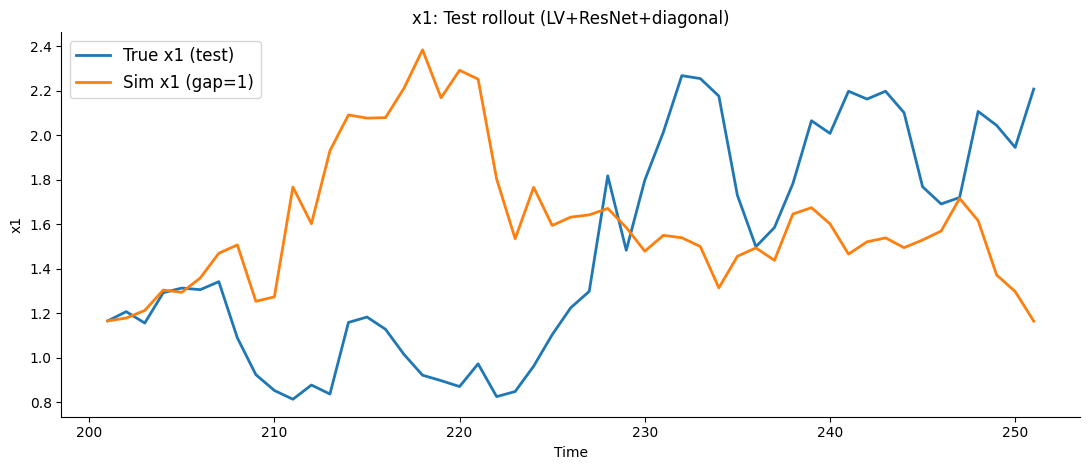

🖼 Saved plot: out_pdf_like/plots\rollout_2d_test_x1.png


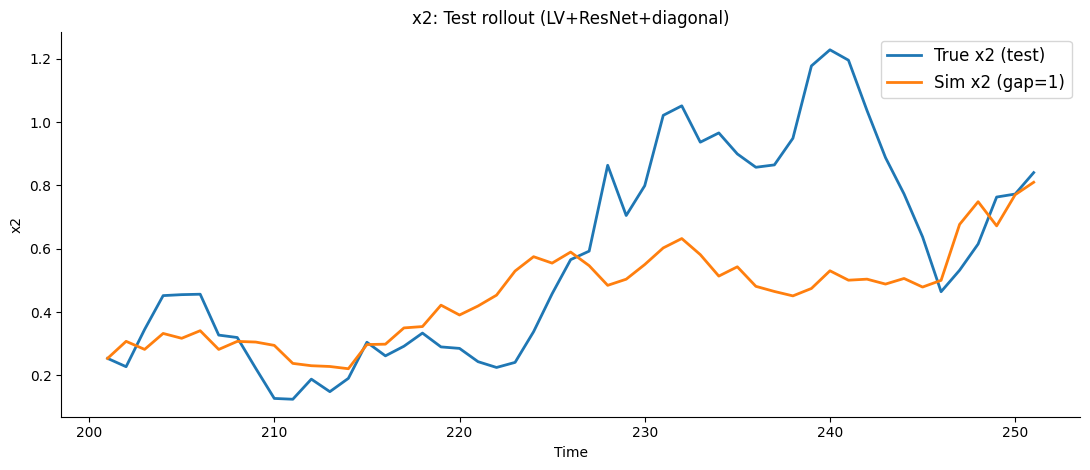

🖼 Saved plot: out_pdf_like/plots\rollout_2d_test_x2.png


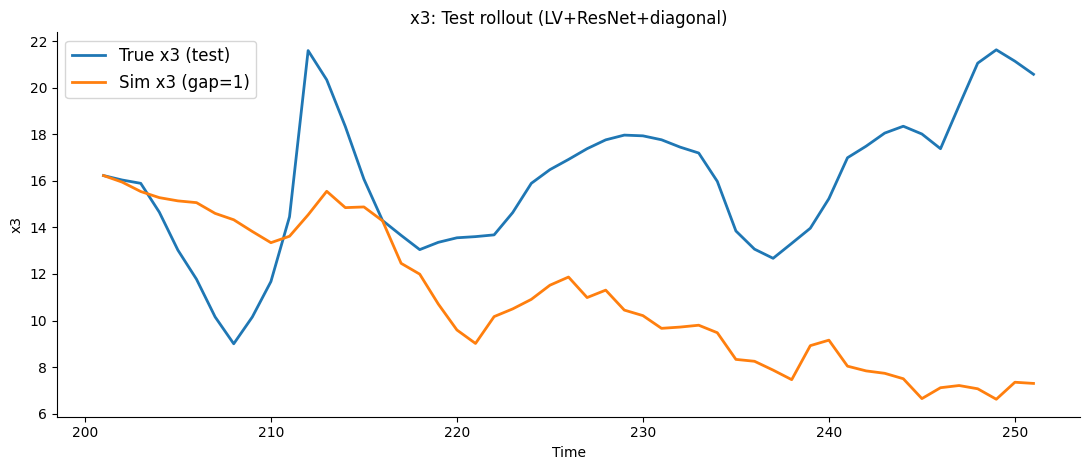

🖼 Saved plot: out_pdf_like/plots\rollout_2d_test_x3.png


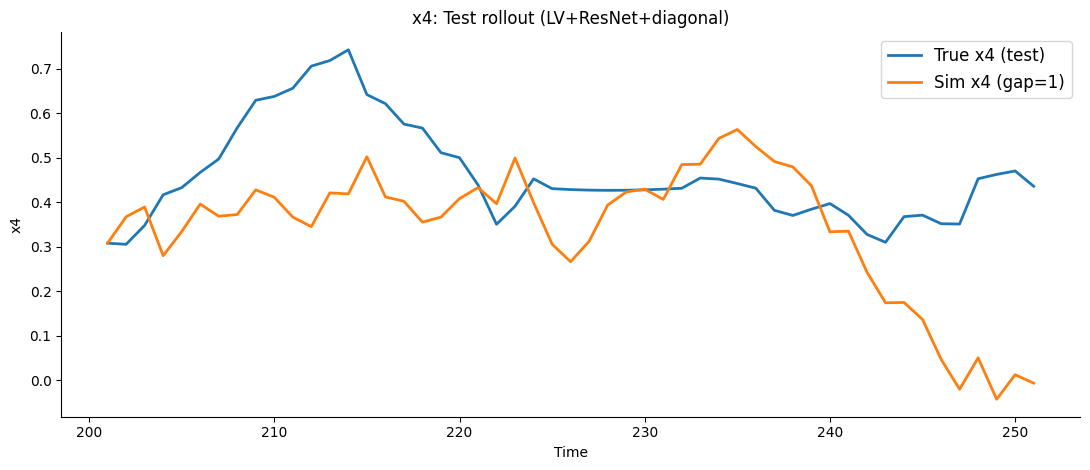

🖼 Saved plot: out_pdf_like/plots\rollout_2d_test_x4.png
✅ Done: deterministic training + curves + rollout plots


In [ ]:
# ============================================
# AW-AOB-NOB-PAO-GAO
# ============================================

# ========= 在导入 TensorFlow 之前：固定种子/确定性 =========
import os, random, json
import numpy as np

GLOBAL_SEED = int(os.environ.get("GLOBAL_SEED", "42"))
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # 极致复现可强制 CPU

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
# =========================================================

import sys, csv
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

try:
    tf.config.experimental.enable_op_determinism()
except TypeError:
    try:
        tf.config.experimental.enable_op_determinism(True)
    except Exception:
        pass

tf.random.set_seed(GLOBAL_SEED)

import tensorflow_probability as tfp
from tensorflow.keras import layers, regularizers
import keras
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

tf.keras.backend.set_floatx('float64')
NUMBER_TYPE = tf.float64
tfd = tfp.distributions
np.set_printoptions(suppress=True, precision=6)


# ==================== 全局数值控制 ====================

class Numerics:
    STD_FLOOR = tf.cast(1e-13, NUMBER_TYPE)

    @staticmethod
    def set_std_floor(v):
        Numerics.STD_FLOOR = tf.cast(v, NUMBER_TYPE)

    @staticmethod
    def get_std_floor():
        return Numerics.STD_FLOOR


def softplus_floor(x):
    return tf.nn.softplus(x) + Numerics.get_std_floor()


# ==================== (新增) meta 保存/加载工具 ====================

def _default_meta_path_from_weight(weight_path: str) -> str:
    base, _ = os.path.splitext(weight_path)
    return base + "_meta.npz"

def _default_cfg_path_from_weight(weight_path: str) -> str:
    base, _ = os.path.splitext(weight_path)
    return base + "_config.json"

def save_run_meta_npz(meta_path: str,
                      idx_tr, idx_va, idx_te,
                      mu_x, sd_x, mu_z, sd_z,
                      cfg: dict,
                      N: int):
    os.makedirs(os.path.dirname(meta_path) or ".", exist_ok=True)

    def _pack(arr):
        return np.array([]) if arr is None else np.asarray(arr)

    # 只保存对“加载复现/画图”关键的字段（避免 meta 太大/太脆弱）
    meta = dict(
        N=int(N),
        idx_tr=np.asarray(idx_tr, dtype=np.int64),
        idx_va=np.asarray(idx_va, dtype=np.int64),
        idx_te=np.asarray(idx_te, dtype=np.int64),
        mu_x=_pack(mu_x),
        sd_x=_pack(sd_x),
        mu_z=_pack(mu_z),
        sd_z=_pack(sd_z),

        # 关键开关/结构（用于 sanity check）
        standardize_x=bool(cfg.get("standardize_x", True)),
        standardize_z=bool(cfg.get("standardize_z", True)),
        cond_mode=str(cfg.get("cond_mode", "mean")),
        diff_type=str(cfg.get("diff_type", "diagonal")),

        # 维度信息（后续构建模型用）
        n_x=int(len(cfg["state_cols"])),
        n_z=int(len(cfg["param_cols"])),
        n_param=int(2 * len(cfg["param_cols"])),  # C=[z_agg, dz]
        state_cols=np.array(cfg["state_cols"], dtype=object),
        param_cols=np.array(cfg["param_cols"], dtype=object),
        step_col=str(cfg.get("step_col", "step")),
        split_ratios=np.array(cfg.get("split_ratios", (0.8, 0.1, 0.1)), dtype=np.float64),
        gaps=np.array(cfg.get("gaps", []), dtype=np.int64),
        rollout_gap=int(cfg.get("rollout_gap", 1)),
        seed=int(cfg.get("seed", GLOBAL_SEED)),
        data_xlsx=str(cfg.get("data_xlsx", "")),
        use_synthetic=bool(cfg.get("use_synthetic", False)),
    )
    np.savez(meta_path, **meta)
    print(f"✅ Saved run meta: {meta_path}")

def save_cfg_snapshot_json(cfg_path: str, cfg: dict):
    os.makedirs(os.path.dirname(cfg_path) or ".", exist_ok=True)
    # json 可序列化的浅拷贝
    def _jsonable(x):
        if isinstance(x, (np.integer, np.floating)):
            return x.item()
        if isinstance(x, (np.ndarray,)):
            return x.tolist()
        return x
    cfg_dump = {k: _jsonable(v) for k, v in cfg.items()}
    with open(cfg_path, "w", encoding="utf-8") as f:
        json.dump(cfg_dump, f, ensure_ascii=False, indent=2)
    print(f"✅ Saved config snapshot: {cfg_path}")

def load_run_meta_npz(meta_path: str) -> dict:
    meta = np.load(meta_path, allow_pickle=True)
    out = {k: meta[k] for k in meta.files}

    # 还原 None
    def _maybe_none(arr):
        arr = np.asarray(arr)
        return None if arr.size == 0 else arr
    out["mu_x"] = _maybe_none(out.get("mu_x", np.array([])))
    out["sd_x"] = _maybe_none(out.get("sd_x", np.array([])))
    out["mu_z"] = _maybe_none(out.get("mu_z", np.array([])))
    out["sd_z"] = _maybe_none(out.get("sd_z", np.array([])))
    return out


# ==================== 数据合成（可选） ====================

def generate_fluctuating_params(n_steps, mutation_step=10000, rng=None):
    if rng is None:
        rng = np.random.default_rng(GLOBAL_SEED)
    Z1_stable = 15 + 0.1 * rng.standard_normal(n_steps)
    Z2_stable = 1 + 0.1 * rng.standard_normal(n_steps)
    Z3_before = 5 + 0.1 * rng.standard_normal(mutation_step)
    Z3_after = 0.1 + 0.1 * rng.standard_normal(n_steps - mutation_step)
    Z3_mut = np.concatenate([Z3_before, Z3_after])
    return np.vstack([Z1_stable, Z2_stable, Z3_mut]).T


def generate_sde_time_series(total_steps=20000, step_size=0.01,
                             mutation_step=10000,
                             out_path="data/sde_time_series_mutationz3.xlsx",
                             seed=42):
    os.makedirs("data", exist_ok=True)
    rng = np.random.default_rng(seed)
    a_aob, NTm_aob, p_aob = 139, 55, 0.39
    a_het, NTm_het, p_het = 520, 199, 0.06
    params = generate_fluctuating_params(total_steps, mutation_step, rng)

    x1 = [rng.uniform(0.1, 0.9)]
    x2 = [rng.uniform(0.1, 0.9)]
    for i in range(total_steps - 1):
        Z1, Z2, Z3 = params[i]
        alpha_aob = 0.027 * Z1 - 0.026 * Z2
        drift_aob = ((NTm_aob * p_aob) / a_aob
                     - (NTm_aob / a_aob) * x1[-1]
                     + (2 * alpha_aob / a_aob) * x1[-1] * (1 - x1[-1]))
        diffusion_aob = np.sqrt(2 * x1[-1] * (1 - x1[-1]) / a_aob)
        dW = rng.normal(0, np.sqrt(step_size))
        x1_new = x1[-1] + drift_aob * step_size + diffusion_aob * dW

        alpha_het = -0.08 * Z3
        drift_het = ((NTm_het * p_het) / a_het
                     - (NTm_het / a_het) * x2[-1]
                     + (2 * alpha_het / a_het) * x2[-1] * (1 - x2[-1]))
        diffusion_het = np.sqrt(2 * x2[-1] * (1 - x2[-1]) / a_het)
        dW = rng.normal(0, np.sqrt(step_size))
        x2_new = x2[-1] + drift_het * step_size + diffusion_het * dW

        x1.append(np.clip(x1_new, 0, 1))
        x2.append(np.clip(x2_new, 0, 1))

    df = pd.DataFrame({
        "step": np.arange(total_steps) * step_size,
        "x1": x1,
        "x2": x2,
        "Z1": params[:, 0],
        "Z2": params[:, 1],
        "Z3": params[:, 2],
    })

    B = df["x1"] + df["x2"] + 1e-12
    df["x1_frac"] = df["x1"] / B
    df["x2_frac"] = df["x2"] / B
    df["Z2_log"] = np.log1p(df["Z2"])

    df.to_excel(out_path, index=False)
    print(f"✅ Synthetic series saved: {out_path}")
    return df


# ==================== LV 先验层 ====================

class LVDrift(tf.keras.layers.Layer):
    def __init__(self, n_x, trainable=True, dtype=tf.float64, name="lv_prior"):
        super().__init__(name=name, dtype=dtype)
        self.n_x = n_x
        self.r = self.add_weight("r", shape=(n_x,),
                                 initializer="zeros",
                                 trainable=trainable, dtype=dtype)
        self.A = self.add_weight("A", shape=(n_x, n_x),
                                 initializer="zeros",
                                 trainable=trainable, dtype=dtype)

    def call(self, x):
        v = self.r + tf.linalg.matvec(self.A, x, transpose_a=True)
        return x * v


# ==================== Normal 近似分布构造 ====================

class ModelBuilder:
    @staticmethod
    def define_normal_distribution(yn_, step_size_, drift_, diffusivity_, diffusivity_type):
        safe_step = tf.maximum(step_size_, tf.cast(1e-12, step_size_.dtype))
        floor = Numerics.get_std_floor()

        if diffusivity_type == "diagonal":
            std = tf.maximum(diffusivity_, floor)
            return tfd.MultivariateNormalDiag(
                loc=(yn_ + step_size_ * drift_),
                scale_diag=tf.math.sqrt(safe_step) * std,
                name="approx_normal"
            )

        elif diffusivity_type == "triangular":
            tril_step_size = tf.math.sqrt(safe_step)
            n_dim = K.shape(yn_)[-1]
            full_shape = n_dim * n_dim
            step_size_matrix = tf.broadcast_to(
                tril_step_size, [K.shape(step_size_)[0], full_shape]
            )
            step_size_matrix = tf.reshape(step_size_matrix, (-1, n_dim, n_dim))

            L = diffusivity_
            d = tf.linalg.diag_part(L)
            L = L - tf.linalg.diag(d) + tf.linalg.diag(tf.abs(d) + floor)

            return tfd.MultivariateNormalTriL(
                loc=(yn_ + step_size_ * drift_),
                scale_tril=tf.multiply(step_size_matrix, L),
                name="approx_normal"
            )

        elif diffusivity_type == "spd":
            spd_step = tf.math.sqrt(safe_step)
            n_dim = K.shape(yn_)[-1]
            full_shape = n_dim * n_dim
            step_size_matrix = tf.broadcast_to(
                spd_step, [K.shape(step_size_)[0], full_shape]
            )
            step_size_matrix = tf.reshape(step_size_matrix, (-1, n_dim, n_dim))

            L = diffusivity_
            d = tf.linalg.diag_part(L)
            L = L - tf.linalg.diag(d) + tf.linalg.diag(tf.abs(d) + floor)
            cov = tf.linalg.matmul(L, L, transpose_b=True)

            eye = tf.eye(tf.shape(cov)[-1], dtype=cov.dtype)[None, :, :]
            cov = cov + (floor ** 2) * eye
            cov = tf.multiply(step_size_matrix, cov)
            chol = tf.linalg.cholesky(cov)

            return tfd.MultivariateNormalTriL(
                loc=(yn_ + step_size_ * drift_),
                scale_tril=chol,
                name="approx_normal"
            )

        elif diffusivity_type == "auto":
            n_dim = int(yn_.shape[-1] or K.int_shape(yn_)[-1])
            k = n_dim * (n_dim + 1) // 2

            d_raw = diffusivity_[:, 0:n_dim]
            tri_flat = diffusivity_[:, n_dim:n_dim + k]
            spd_flat = diffusivity_[:, n_dim + k:n_dim + 2 * k]
            gate_logits = diffusivity_[:, n_dim + 2 * k:n_dim + 2 * k + 3]
            w = tf.nn.softmax(gate_logits, axis=-1)

            sig = softplus_floor(d_raw)
            D = tf.linalg.diag(sig)
            cov_diag = tf.linalg.matmul(D, D, transpose_b=True)

            L1 = tfp.math.fill_triangular(tri_flat)
            d1 = tf.linalg.diag_part(L1)
            L1 = L1 - tf.linalg.diag(d1) + tf.linalg.diag(tf.abs(d1) + floor)
            cov_tri = tf.linalg.matmul(L1, L1, transpose_b=True)

            L2 = tfp.math.fill_triangular(spd_flat)
            d2 = tf.linalg.diag_part(L2)
            L2 = L2 - tf.linalg.diag(d2) + tf.linalg.diag(tf.abs(d2) + floor)
            cov_spd = tf.linalg.matmul(L2, L2, transpose_b=True)

            cov = (w[:, 0][:, None, None] * cov_diag +
                   w[:, 1][:, None, None] * cov_tri +
                   w[:, 2][:, None, None] * cov_spd)
            eye = tf.eye(n_dim, dtype=yn_.dtype)[None, :, :]
            cov = cov + (floor ** 2) * eye
            cov = cov * tf.reshape(safe_step, (-1, 1, 1))
            scale_tril = tf.linalg.cholesky(cov)

            return tfd.MultivariateNormalTriL(
                loc=(yn_ + step_size_ * drift_),
                scale_tril=scale_tril,
                name="approx_normal"
            )

        else:
            raise ValueError(f"Unsupported diffusivity_type {diffusivity_type}")


# ==================== ResNet SDE 子模型（均值=LV+残差） ====================

def define_sde_with_lv(n_input_dimensions,
                       n_output_dimensions,
                       n_layers,
                       n_dim_per_layer,
                       name,
                       diffusivity_type="diagonal",
                       activation="tanh",
                       dtype=tf.float64,
                       n_parameter_dimensions=0,
                       lv_trainable=True,
                       dropout_rate=0.05,
                       l2_weight=1e-4,
                       seed=GLOBAL_SEED):
    reg = regularizers.l2(l2_weight) if l2_weight and l2_weight > 0 else None
    act_fn = tf.keras.activations.get(activation)

    inputs = layers.Input((n_input_dimensions + n_parameter_dimensions,),
                          dtype=dtype, name=name + "_inputs")

    x_only = layers.Lambda(lambda u: u[:, :n_input_dimensions],
                           name=f"{name}_x_only")(inputs)
    lv_term = LVDrift(n_x=n_input_dimensions,
                      trainable=lv_trainable,
                      dtype=dtype,
                      name=f"{name}_lv_prior")(x_only)

    dense_init = tf.keras.initializers.GlorotUniform(seed=seed)

    h = layers.Dense(n_dim_per_layer,
                     activation=act_fn,
                     kernel_initializer=dense_init,
                     bias_initializer="zeros",
                     kernel_regularizer=reg,
                     dtype=dtype,
                     name=f"{name}_mean_res_in")(inputs)

    for i in range(n_layers):
        h_res = layers.Dense(n_dim_per_layer,
                             activation=act_fn,
                             kernel_initializer=dense_init,
                             bias_initializer="zeros",
                             kernel_regularizer=reg,
                             dtype=dtype,
                             name=f"{name}_mean_res_block{i}_dense1")(h)
        if dropout_rate and dropout_rate > 0:
            h_res = layers.Dropout(dropout_rate, seed=seed,
                                   name=f"{name}_mean_res_block{i}_dropout")(h_res)
        h_res = layers.Dense(n_dim_per_layer,
                             activation=None,
                             kernel_initializer=dense_init,
                             bias_initializer="zeros",
                             kernel_regularizer=reg,
                             dtype=dtype,
                             name=f"{name}_mean_res_block{i}_dense2")(h_res)
        h = layers.Add(name=f"{name}_mean_res_block{i}_add")([h, h_res])
        h = layers.Activation(act_fn, name=f"{name}_mean_res_block{i}_act")(h)

    mean_residual = layers.Dense(n_output_dimensions,
                                 activation=None,
                                 kernel_initializer=dense_init,
                                 bias_initializer="zeros",
                                 kernel_regularizer=reg,
                                 dtype=dtype,
                                 name=f"{name}_mean_res_out")(h)
    out_mean = layers.Add(name=f"{name}_output_mean")([lv_term, mean_residual])

    small_init = 1e-2
    ru_init = tf.keras.initializers.RandomUniform(minval=-small_init,
                                                  maxval=small_init,
                                                  seed=seed)

    h2 = layers.Dense(n_dim_per_layer,
                      activation=act_fn,
                      kernel_initializer=ru_init,
                      bias_initializer=ru_init,
                      kernel_regularizer=reg,
                      dtype=dtype,
                      name=f"{name}_std_in")(inputs)

    for i in range(n_layers):
        h2_res = layers.Dense(n_dim_per_layer,
                              activation=act_fn,
                              kernel_initializer=ru_init,
                              bias_initializer=ru_init,
                              kernel_regularizer=reg,
                              dtype=dtype,
                              name=f"{name}_std_block{i}_dense1")(h2)
        if dropout_rate and dropout_rate > 0:
            h2_res = layers.Dropout(dropout_rate, seed=seed,
                                    name=f"{name}_std_block{i}_dropout")(h2_res)
        h2_res = layers.Dense(n_dim_per_layer,
                              activation=None,
                              kernel_initializer=ru_init,
                              bias_initializer=ru_init,
                              kernel_regularizer=reg,
                              dtype=dtype,
                              name=f"{name}_std_block{i}_dense2")(h2_res)
        h2 = layers.Add(name=f"{name}_std_block{i}_add")([h2, h2_res])
        h2 = layers.Activation(act_fn, name=f"{name}_std_block{i}_act")(h2)

    if diffusivity_type == "diagonal":
        out_std = layers.Dense(
            n_output_dimensions,
            activation=lambda x: softplus_floor(x),
            kernel_initializer=ru_init,
            bias_initializer=ru_init,
            kernel_regularizer=reg,
            dtype=dtype,
            name=f"{name}_output_std"
        )(h2)

    elif diffusivity_type == "triangular":
        out_tril = layers.Dense(
            n_output_dimensions * (n_output_dimensions + 1) // 2,
            activation="linear",
            kernel_initializer=ru_init,
            bias_initializer=ru_init,
            kernel_regularizer=reg,
            dtype=dtype,
            name=f"{name}_output_cholesky"
        )(h2)

        def make_tri_matrix(z):
            L = tfp.math.fill_triangular(z)
            d = tf.linalg.diag_part(L)
            return L - tf.linalg.diag(d) + tf.linalg.diag(tf.abs(d) + Numerics.get_std_floor())

        out_std = layers.Lambda(make_tri_matrix, name=f"{name}_std_tril")(out_tril)

    elif diffusivity_type == "spd":
        out_tril = layers.Dense(
            n_output_dimensions * (n_output_dimensions + 1) // 2,
            activation="linear",
            kernel_initializer=ru_init,
            bias_initializer=ru_init,
            kernel_regularizer=reg,
            dtype=dtype,
            name=f"{name}_output_spd"
        )(h2)

        def make_spd(z):
            L = tfp.math.fill_triangular(z)
            d = tf.linalg.diag_part(L)
            L = L - tf.linalg.diag(d) + tf.linalg.diag(tf.abs(d) + Numerics.get_std_floor())
            return tf.linalg.matmul(L, L, transpose_b=True)

        out_std = layers.Lambda(make_spd, name=f"{name}_std_spd")(out_tril)

    elif diffusivity_type == "auto":
        diag_std = layers.Dense(n_output_dimensions, activation="linear",
                                kernel_initializer=ru_init, bias_initializer=ru_init,
                                kernel_regularizer=reg, dtype=dtype,
                                name=f"{name}_auto_diag_raw")(h2)
        tri_flat = layers.Dense(n_output_dimensions * (n_output_dimensions + 1) // 2,
                                activation="linear", kernel_initializer=ru_init,
                                bias_initializer=ru_init, kernel_regularizer=reg,
                                dtype=dtype, name=f"{name}_auto_tri_flat")(h2)
        spd_flat = layers.Dense(n_output_dimensions * (n_output_dimensions + 1) // 2,
                                activation="linear", kernel_initializer=ru_init,
                                bias_initializer=ru_init, kernel_regularizer=reg,
                                dtype=dtype, name=f"{name}_auto_spd_flat")(h2)
        gate_logits = layers.Dense(3, activation="linear",
                                   kernel_initializer=ru_init, bias_initializer="zeros",
                                   kernel_regularizer=reg, dtype=dtype,
                                   name=f"{name}_auto_gate_logits")(h2)
        out_std = layers.Concatenate(name=f"{name}_auto_concat")(
            [diag_std, tri_flat, spd_flat, gate_logits]
        )
    else:
        raise ValueError(f"Unsupported diffusivity_type {diffusivity_type}")

    return tf.keras.Model(inputs, [out_mean, out_std], name=name + "_gaussian_process")


# ==================== PDF 一步似然网络 ====================

class SDEApproximationNetwork(tf.keras.Model):
    def __init__(self, sde_model: tf.keras.Model,
                 step_size=None, n_parameters=0,
                 method="euler", diffusivity_type="diagonal",
                 gate_entropy_lambda=0.0, **kwargs):
        super().__init__(**kwargs)
        assert method == "euler"
        self.sde_model = sde_model
        self.step_size = step_size
        self.n_parameters = n_parameters
        self.method = method
        self.diffusivity_type = diffusivity_type
        self.gate_entropy_lambda = float(gate_entropy_lambda)

    @staticmethod
    def split_inputs(inputs, step_size=None, n_parameters=0):
        if step_size is None:
            total_cols = inputs.shape[1]
            n_size = (total_cols - 1 - n_parameters) // 2
            step = inputs[:, :1]
            rem = inputs[:, 1:]
            if n_parameters > 0:
                x_n, p_n, x_np1 = tf.split(
                    rem, num_or_size_splits=[n_size, n_parameters, n_size], axis=1
                )
            else:
                x_n, x_np1 = tf.split(rem, num_or_size_splits=2, axis=1)
                p_n = None
            return step, x_n, p_n, x_np1
        else:
            if n_parameters > 0:
                n_size = inputs.shape[1] // 2
                x_n, p_n, x_np1 = tf.split(
                    inputs,
                    num_or_size_splits=[n_size - n_parameters,
                                        n_parameters,
                                        n_size - n_parameters],
                    axis=1
                )
            else:
                x_n, x_np1 = tf.split(inputs, num_or_size_splits=2, axis=1)
                p_n = None
            return step_size, x_n, p_n, x_np1

    def call_xn(self, inputs_xn, param_xn=None):
        if param_xn is not None:
            return self.sde_model(tf.concat([inputs_xn, param_xn], axis=1))
        return self.sde_model(inputs_xn)

    def call(self, inputs):
        step_size, x_n, p_n, x_np1 = SDEApproximationNetwork.split_inputs(
            inputs, self.step_size, self.n_parameters
        )
        if p_n is not None:
            drift_, diff_ = self.sde_model(tf.concat([x_n, p_n], axis=1))
        else:
            drift_, diff_ = self.sde_model(x_n)

        approx_normal = ModelBuilder.define_normal_distribution(
            x_n, step_size, drift_, diff_, self.diffusivity_type
        )
        log_prob = approx_normal.log_prob(x_np1)
        sample_distortion = -tf.reduce_mean(log_prob, axis=-1)
        distortion = tf.reduce_mean(sample_distortion)
        loss = distortion + 2 * np.log(2 * np.pi) / np.log(10) * tf.cast(tf.shape(x_n)[1], NUMBER_TYPE)

        if self.diffusivity_type == "auto":
            n_dim = int(x_n.shape[-1])
            k = n_dim * (n_dim + 1) // 2
            gate_logits = diff_[:, n_dim + 2 * k:n_dim + 2 * k + 3]
            w = tf.nn.softmax(gate_logits, axis=-1)
            self.add_metric(tf.reduce_mean(w[:, 0]), name="gate_diag", aggregation="mean")
            self.add_metric(tf.reduce_mean(w[:, 1]), name="gate_tri", aggregation="mean")
            self.add_metric(tf.reduce_mean(w[:, 2]), name="gate_spd", aggregation="mean")
            if self.gate_entropy_lambda > 0.0:
                entropy = -tf.reduce_mean(tf.reduce_sum(w * tf.math.log(w + 1e-8), axis=-1))
                loss = loss + self.gate_entropy_lambda * entropy

        self.add_loss(loss)
        self.add_metric(distortion, name="distortion", aggregation="mean")

        if p_n is not None:
            x_n = tf.concat([x_n, p_n], axis=1)
        return self.sde_model(x_n)


# ==================== 训练包装 & rollout ====================

class EMASmoothingCallback(keras.callbacks.Callback):
    def __init__(self, monitor="val_loss", alpha=0.2):
        super().__init__()
        self.monitor = monitor
        self.alpha = float(alpha)
        self.ema = None

    def on_epoch_end(self, epoch, logs=None):
        if logs is None or self.monitor not in logs:
            return
        val = float(logs[self.monitor])
        self.ema = val if self.ema is None else self.alpha * val + (1 - self.alpha) * self.ema
        logs[self.monitor + "_ema"] = self.ema


class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def __init__(self, monitor_keys=("loss", "val_loss",
                                     "distortion", "val_distortion",
                                     "gate_diag", "gate_tri", "gate_spd")):
        super().__init__()
        self.keys = monitor_keys

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        msg = [f"Epoch {epoch + 1:04d}"]
        for k in self.keys:
            if k in logs:
                try:
                    v = float(logs[k])
                    msg.append(f"{k}={v:.6f}")
                except Exception:
                    msg.append(f"{k}={logs[k]}")
        sys.stdout.write("\r" + " | ".join(msg))
        sys.stdout.flush()


class SDEIdentification:
    def __init__(self, model: SDEApproximationNetwork,
                 lr=1e-4, weight_decay=1e-4, clipnorm=1.0):
        self.model = model
        opt = tf.keras.optimizers.AdamW(
            learning_rate=lr,
            weight_decay=weight_decay,
            global_clipnorm=clipnorm
        )
        self.model.compile(optimizer=opt)

    def train_model_matrix(self, train_full, val_full,
                           epochs=1000, batch_size=512,
                           es_cfg=None, rlrop_cfg=None, ckpt_cfg=None):
        callbacks = [LossAndErrorPrintingCallback()]

        if es_cfg and es_cfg.get("use_ema", False):
            callbacks.append(EMASmoothingCallback(
                monitor=es_cfg.get("monitor", "val_loss"),
                alpha=es_cfg.get("ema_alpha", 0.2)
            ))

        if es_cfg:
            monitor_name = es_cfg.get("monitor", "val_loss")
            if es_cfg.get("use_ema", False):
                monitor_name = monitor_name + "_ema"
            es_kwargs = dict(
                monitor=monitor_name,
                min_delta=es_cfg.get("min_delta", 0.0),
                patience=es_cfg.get("patience", 200),
                mode=es_cfg.get("mode", "min"),
                restore_best_weights=es_cfg.get("restore_best_weights", True),
                baseline=es_cfg.get("baseline", None)
            )
            try:
                es = EarlyStopping(start_from_epoch=es_cfg.get("start_from_epoch", 0), **es_kwargs)
            except TypeError:
                es = EarlyStopping(**es_kwargs)
            callbacks.append(es)

        if rlrop_cfg and rlrop_cfg.get("enabled", False):
            monitor_name = rlrop_cfg.get("monitor", "val_loss")
            if (rlrop_cfg.get("use_ema_as_monitor", False) and es_cfg and es_cfg.get("use_ema", False)):
                monitor_name = es_cfg.get("monitor", "val_loss") + "_ema"
            rlp = ReduceLROnPlateau(
                monitor=monitor_name,
                factor=rlrop_cfg.get("factor", 0.5),
                patience=rlrop_cfg.get("patience", 200),
                mode=rlrop_cfg.get("mode", "min"),
                cooldown=rlrop_cfg.get("cooldown", 0),
                min_delta=rlrop_cfg.get("min_delta", 1e-6),
                min_lr=rlrop_cfg.get("min_lr", 1e-6),
                verbose=1
            )
            callbacks.append(rlp)

        if ckpt_cfg and ckpt_cfg.get("enabled", False):
            os.makedirs(os.path.dirname(ckpt_cfg["filepath"]), exist_ok=True)
            mc = ModelCheckpoint(
                filepath=ckpt_cfg["filepath"],
                monitor=ckpt_cfg.get("monitor", "val_loss"),
                mode=ckpt_cfg.get("mode", "min"),
                save_best_only=True,
                save_weights_only=True,
                verbose=1
            )
            callbacks.append(mc)

        hist = self.model.fit(
            x=train_full, y=None,
            epochs=epochs, batch_size=batch_size, verbose=0,
            validation_data=(val_full, None),
            callbacks=callbacks,
            shuffle=False
        )
        print("\n✅ Training done.")
        return hist

    def sample_path(self, x0, step_size, NT, N_iterates,
                    param0=None, diffusivity_type="diagonal",
                    map_every_iteration=None):
        step_size = tf.cast(np.ones((N_iterates, 1)) * np.array(step_size), dtype=NUMBER_TYPE)
        paths = [np.ones((N_iterates, 1)) @ np.array(x0).reshape(1, -1)]
        for _ in range(NT):
            x_n = paths[-1]
            if param0 is not None:
                mu, sig = self.model.call_xn(tf.concat([x_n, param0], axis=1))
            else:
                mu, sig = self.model.call_xn(x_n)
            approx_normal = ModelBuilder.define_normal_distribution(x_n, step_size, mu, sig, diffusivity_type)
            x_np1 = approx_normal.sample()
            x_i = keras.backend.eval(x_np1)
            if map_every_iteration is not None:
                x_i = map_every_iteration(x_i)
            paths.append(x_i)
        return [np.row_stack([paths[k][i] for k in range(len(paths))])
                for i in range(N_iterates)]


# ====================== 数据对构造/切分等 ======================

def aggregate_z_segment(Z, t, gap, mode='mean'):
    seg = Z[t:t + gap]
    if mode == 'mean':
        return seg.mean(axis=0)
    if mode == 'sum':
        return seg.sum(axis=0)
    if mode == 'last':
        return seg[-1]
    if mode == 'start':
        return seg[0]
    return seg.mean(axis=0)


def build_multi_h_pairs_on_block(X_blk, Z_blk, T_blk, gaps,
                                 max_per_gap=3000,
                                 cond_mode='mean', rng=None):
    if rng is None:
        rng = np.random.default_rng(GLOBAL_SEED)
    Xn_list, Xnp1_list, C_list, H_list = [], [], [], []
    M = len(X_blk)
    for gap in gaps:
        avail = M - gap
        if avail <= 0:
            continue
        idx = np.arange(avail)
        if len(idx) > max_per_gap:
            idx = rng.choice(idx, size=max_per_gap, replace=False)
        h_vals = (T_blk[idx + gap] - T_blk[idx]).reshape(-1, 1)

        C_rows = []
        for t in idx:
            z_agg = aggregate_z_segment(Z_blk, t, gap, cond_mode)
            dz = Z_blk[t + gap - 1] - Z_blk[t]
            C_rows.append(np.concatenate([z_agg, dz]))
        C_seg = np.vstack(C_rows)

        Xn_list.append(X_blk[idx])
        Xnp1_list.append(X_blk[idx + gap])
        C_list.append(C_seg)
        H_list.append(h_vals)

    if not Xn_list:
        raise RuntimeError("该块没有可用 (t, t+gap) 样本；检查 GAPS 或块长度。")

    return (np.vstack(Xn_list).astype(np.float64),
            np.vstack(Xnp1_list).astype(np.float64),
            np.vstack(C_list).astype(np.float64),
            np.vstack(H_list).astype(np.float64))


def build_multi_h_pairs_cross(X_all, Z_all, T_all,
                              start_idx, end_idx, gaps,
                              max_per_gap=3000,
                              cond_mode='mean', rng=None):
    if rng is None:
        rng = np.random.default_rng(GLOBAL_SEED)

    start_idx = np.asarray(start_idx)
    end_mask = np.zeros(len(X_all), dtype=bool)
    end_mask[np.asarray(end_idx)] = True

    Xn_list, Xnp1_list, C_list, H_list = [], [], [], []

    for gap in gaps:
        ok = (start_idx + gap < len(X_all))
        t_candidates = start_idx[ok]
        t_candidates = t_candidates[end_mask[t_candidates + gap]]
        if len(t_candidates) == 0:
            continue
        if len(t_candidates) > max_per_gap:
            t_candidates = rng.choice(t_candidates, size=max_per_gap, replace=False)

        h_vals = (T_all[t_candidates + gap] - T_all[t_candidates]).reshape(-1, 1)

        C_rows = []
        for t in t_candidates:
            z_agg = aggregate_z_segment(Z_all, t, gap, cond_mode)
            dz = Z_all[t + gap - 1] - Z_all[t]
            C_rows.append(np.concatenate([z_agg, dz]))
        C_seg = np.vstack(C_rows)

        Xn_list.append(X_all[t_candidates])
        Xnp1_list.append(X_all[t_candidates + gap])
        C_list.append(C_seg)
        H_list.append(h_vals)

    if not Xn_list:
        raise RuntimeError("跨段没有可用 (t, t+gap) 样本；检查 gaps、split 或 max_per_gap。")

    return (np.vstack(Xn_list).astype(np.float64),
            np.vstack(Xnp1_list).astype(np.float64),
            np.vstack(C_list).astype(np.float64),
            np.vstack(H_list).astype(np.float64))


def fit_stats(arr):
    mu = arr.mean(axis=0, keepdims=True)
    sd = arr.std(axis=0, keepdims=True) + 1e-12
    return mu, sd


def apply_stats(arr, mu, sd):
    return (arr - mu) / sd


def pack_inputs(H, Xn, C, Xnp1):
    left = np.column_stack([H, Xn, C])
    return np.column_stack([left, Xnp1])


def warm_start_lv_from_paired_data(train_full, sde_model,
                                   n_x, n_z,
                                   lv_layer_name="sde_lv_prior",
                                   ridge=1e-4):
    # 这里 n_z 实际上传的是 n_param（即 C 的维度），与你原脚本保持一致
    h = train_full[:, :1]
    xn = train_full[:, 1:1 + n_x]
    xp = train_full[:, 1 + n_x + n_z:1 + 2 * n_x + n_z]
    eps = 1e-12
    y = (xp - xn) / (h + eps)

    R = np.zeros((n_x,), dtype=np.float64)
    A = np.zeros((n_x, n_x), dtype=np.float64)

    for i in range(n_x):
        xi = xn[:, i:i + 1]
        Phi = np.concatenate([xi, xi * xn], axis=1)
        y_i = y[:, i:i + 1]
        I = np.eye(Phi.shape[1], dtype=np.float64)
        w = np.linalg.solve(Phi.T @ Phi + ridge * I, Phi.T @ y_i).ravel()
        R[i] = w[0]
        A[i, :] = w[1:]

    lv_layers = [l for l in sde_model.layers if l.name == lv_layer_name]
    if not lv_layers:
        raise RuntimeError(f"Didn't find LV layer named '{lv_layer_name}'.")
    lv_layer = lv_layers[0]
    lv_layer.r.assign(R)
    lv_layer.A.assign(A)
    print("✅ Warm-start LV prior with empirical (r, A).")


def simulate_path_block(solver: SDEIdentification,
                        X_blk, Z_blk, T_blk,
                        gap=1, cond_mode='mean',
                        diffusivity_type="diagonal",
                        mu_x=None, sd_x=None,
                        mu_z=None, sd_z=None):
    X0 = X_blk[0].copy()
    X0_s = ((X0[None, :] - mu_x) / sd_x)[0] if (mu_x is not None) else X0.copy()

    Nblk = len(T_blk)
    steps = (Nblk - 1) // gap
    x_pred_s = [X0_s.copy()]
    x_curr_s = X0_s.copy()

    for j in range(steps):
        t = j * gap
        if t + gap >= Nblk:
            break
        dt = T_blk[t + gap] - T_blk[t]

        z_agg = aggregate_z_segment(Z_blk, t, gap, cond_mode)
        dz = Z_blk[t + gap - 1] - Z_blk[t]
        zseg = np.concatenate([z_agg, dz]).reshape(1, -1)
        zseg_s = (zseg - mu_z) / sd_z if (mu_z is not None) else zseg

        path_j = solver.sample_path(
            x0=x_curr_s,
            step_size=dt,
            NT=1,
            N_iterates=1,
            param0=zseg_s,
            diffusivity_type=diffusivity_type
        )[0]
        x_next_s = path_j[1]
        x_pred_s.append(x_next_s)
        x_curr_s = x_next_s

    Xsim = np.array(x_pred_s)
    if mu_x is not None:
        Xsim = Xsim * sd_x + mu_x

    Tsim = np.r_[T_blk[0],
                 np.array([T_blk[(k + 1) * gap] for k in range(len(x_pred_s) - 1)])]
    return Xsim, Tsim


def plot_training_curves(history, out_dir, diff_type):
    os.makedirs(out_dir, exist_ok=True)
    H = history.history

    def _maybe_plot(keys, title, fname):
        keys = [k for k in keys if k in H]
        if not keys:
            return
        plt.figure(figsize=(8.8, 4.2))
        for k in keys:
            plt.plot(H[k], label=k)
        plt.xlabel("epoch")
        plt.ylabel("value")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        fpath = os.path.join(out_dir, fname)
        plt.savefig(fpath, dpi=180)
        plt.show()
        print(f"🖼 saved: {fpath}")

    _maybe_plot(["loss", "val_loss", "loss_ema", "val_loss_ema"], "Loss curves", "curve_loss.png")
    _maybe_plot(["distortion", "val_distortion"], "Distortion curves", "curve_distortion.png")
    if diff_type == "auto":
        _maybe_plot(["gate_diag", "gate_tri", "gate_spd"], "Auto-gate (train mean)", "curve_gate.png")

    csv_path = os.path.join(out_dir, "training_history.csv")
    all_keys = sorted(H.keys())
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch"] + all_keys)
        Tlen = len(next(iter(H.values())))
        for i in range(Tlen):
            writer.writerow([i + 1] + [H[k][i] if i < len(H[k]) else "" for k in all_keys])
    print(f"📄 history saved: {csv_path}")


# ==================== (新增) 数据读取函数，绘图/检验复用 ====================

def load_data_arrays(cfg):
    if cfg["use_synthetic"] or (not os.path.exists(cfg["data_xlsx"])):
        df = generate_sde_time_series(
            total_steps=cfg["synthetic_total_steps"],
            step_size=cfg["synthetic_dt"],
            mutation_step=cfg["synthetic_mutation_step"],
            out_path=cfg["synthetic_out_path"],
            seed=cfg["seed"]
        )
    else:
        df = pd.read_excel(cfg["data_xlsx"])

    step_col = cfg["step_col"]
    if step_col in df.columns:
        df = df.sort_values(step_col).reset_index(drop=True)
    else:
        df[step_col] = np.arange(len(df))

    if "Z2" in df.columns and ("Z2_log" in cfg["param_cols"]):
        df["Z2_log"] = np.log1p(df["Z2"])

    X = df[cfg["state_cols"]].to_numpy(np.float64)
    Z = df[cfg["param_cols"]].to_numpy(np.float64)
    T = (df[step_col].to_numpy(np.float64)
         if step_col in df.columns
         else np.arange(len(df), dtype=np.float64))
    return df, X, Z, T


# ==================== (新增) 后续绘图/检验：一行加载训练好的模型 ====================

def load_trained_model_for_plots(cfg,
                                weights_path=None,
                                prefer_best=True,
                                meta_path=None,
                                build_solver=True):
    """
    用于后续绘图/检验 cell 的“最简单入口”：
    model, solver, meta, (df,X,Z,T) = load_trained_model_for_plots(CONFIG)

    - 自动选择权重：prefer_best=True 时优先 best，否则 final
    - 自动读取 meta：默认和权重同名 *_meta.npz（也可传 meta_path）
    - 不重算 split/stats，确保和训练一致
    """
    # 选权重
    if weights_path is None:
        cand = []
        if prefer_best and cfg.get("ckpt_enabled", False):
            cand.append(cfg.get("save_best_weights_path", ""))
        cand.append(cfg.get("save_weights_path", ""))
        weights_path = None
        for p in cand:
            if p and os.path.exists(p):
                weights_path = p
                break
        if weights_path is None:
            raise FileNotFoundError(f"❌ 找不到权重文件，候选：{cand}")

    # 选 meta
    if meta_path is None:
        meta_path = cfg.get("meta_path", _default_meta_path_from_weight(weights_path))
    if not os.path.exists(meta_path):
        raise FileNotFoundError(f"❌ 找不到 meta 文件：{meta_path}（请先用 main(CONFIG) 训练/生成 meta）")

    meta = load_run_meta_npz(meta_path)

    # 读取数据（画图一般也需要）
    df, X, Z, T = load_data_arrays(cfg)

    # 构建网络（不需要 pairs，只需要维度）
    n_x = int(meta["n_x"])
    n_param = int(meta["n_param"])  # 2*n_z

    sde_model = define_sde_with_lv(
        n_input_dimensions=n_x,
        n_output_dimensions=n_x,
        n_layers=cfg["mean_num_layers"],
        n_dim_per_layer=cfg["mean_hidden_dim"],
        name="sde",
        activation=cfg["mean_activation"],
        diffusivity_type=cfg["diff_type"],
        dtype=NUMBER_TYPE,
        n_parameter_dimensions=n_param,
        lv_trainable=cfg["lv_trainable"],
        dropout_rate=cfg.get("dropout_rate", 0.05),
        l2_weight=cfg.get("l2_weight", 1e-4),
        seed=cfg["seed"]
    )

    model = SDEApproximationNetwork(
        sde_model,
        step_size=None,
        n_parameters=n_param,
        method="euler",
        diffusivity_type=cfg["diff_type"],
        gate_entropy_lambda=cfg.get("gate_entropy_lambda", 0.0)
    )

    # build
    dummy_cols = 1 + n_x + n_param + n_x
    _ = model(tf.zeros((1, dummy_cols), dtype=NUMBER_TYPE))

    # load weights
    model.load_weights(weights_path)
    print(f"✅ Loaded weights: {weights_path}")
    print(f"✅ Loaded meta   : {meta_path}")
    print(f"[Time split(meta)] train={len(meta['idx_tr'])}, val={len(meta['idx_va'])}, test={len(meta['idx_te'])}")

    solver = None
    if build_solver:
        solver = SDEIdentification(
            model,
            lr=cfg.get("lr", 1e-4),
            weight_decay=cfg.get("weight_decay", 1e-4),
            clipnorm=cfg.get("global_clipnorm", 1.0)
        )

    return model, solver, meta, (df, X, Z, T)


# ============================== 主流程 ==============================

def main(cfg):
    import gc
    tf.keras.backend.clear_session()
    gc.collect()
    plt.close('all')

    Numerics.set_std_floor(cfg.get("std_min_value", 1e-13))

    np.random.seed(cfg["seed"])
    tf.random.set_seed(cfg["seed"])

    # -------- 读数据 / 合成数据 --------
    df, X, Z, T = load_data_arrays(cfg)

    # ----- 按时间划分：train / val / test -----
    R_TR, R_VA, R_TE = cfg["split_ratios"]
    assert abs(R_TR + R_VA + R_TE - 1.0) < 1e-8
    N = len(T)
    MAXG = max(cfg["gaps"])
    split_tr = int(N * R_TR)
    split_va = int(N * (R_TR + R_VA))

    # train 段内训练一定要 > MAXG（否则 train 内无法做最大 gap 的配对）
    if split_tr <= MAXG:
        split_tr = MAXG + 1

    # val：只有在 val 要段内配对时才需要 > MAXG
    if (not cfg.get("val_cross_pairs", True)) and (split_va - split_tr <= MAXG):
        split_va = split_tr + (MAXG + 1)

    # ✅ test 不做配对时，不要用 MAXG 约束 test_len
    if cfg.get("use_test_pairs", True):
        if (not cfg.get("test_cross_pairs", True)) and (N - split_va <= MAXG):
            split_va = N - (MAXG + 1)

    idx_tr = np.arange(0, split_tr)
    idx_va = np.arange(split_tr, split_va)
    idx_te = np.arange(split_va, N)

    rng = np.random.default_rng(cfg["seed"])

    # ====== 构造 train / val 配对 ======
    Xn_tr, Xnp1_tr, C_tr, H_tr = build_multi_h_pairs_on_block(
        X[idx_tr], Z[idx_tr], T[idx_tr],
        cfg["gaps"], cfg["max_per_gap"], cfg["cond_mode"], rng=rng
    )

    # ====== 构造 val 配对：cross(train->val) + within(val->val) 二者兼有 ======
    val_mode = cfg.get("val_pairs_mode", "cross")  # "cross" | "within" | "both"

    Xn_va_list, Xnp1_va_list, C_va_list, H_va_list = [], [], [], []

    if val_mode in ("cross", "both"):
        Xn_va1, Xnp1_va1, C_va1, H_va1 = build_multi_h_pairs_cross(
            X_all=X, Z_all=Z, T_all=T,
            start_idx=idx_tr, end_idx=idx_va,
            gaps=cfg["gaps"], max_per_gap=cfg["max_per_gap"],
            cond_mode=cfg["cond_mode"], rng=rng
        )
        Xn_va_list.append(Xn_va1); Xnp1_va_list.append(Xnp1_va1)
        C_va_list.append(C_va1);   H_va_list.append(H_va1)

    if val_mode in ("within", "both"):
        Xn_va2, Xnp1_va2, C_va2, H_va2 = build_multi_h_pairs_on_block(
            X[idx_va], Z[idx_va], T[idx_va],
            cfg["gaps"], cfg["max_per_gap"], cfg["cond_mode"], rng=rng
    )
        Xn_va_list.append(Xn_va2); Xnp1_va_list.append(Xnp1_va2)
        C_va_list.append(C_va2);   H_va_list.append(H_va2)

    if not Xn_va_list:
        raise RuntimeError(f"val_pairs_mode={val_mode} produced no validation pairs.")

    Xn_va   = np.vstack(Xn_va_list).astype(np.float64)
    Xnp1_va = np.vstack(Xnp1_va_list).astype(np.float64)
    C_va    = np.vstack(C_va_list).astype(np.float64)
    H_va    = np.vstack(H_va_list).astype(np.float64)


    # ====== test 配对：按开关决定是否跳过 ======
    use_test_pairs = cfg.get("use_test_pairs", True)
    if use_test_pairs:
        if cfg.get("test_cross_pairs", True):
            idx_trva = np.arange(0, split_va)
            Xn_te, Xnp1_te, C_te, H_te = build_multi_h_pairs_cross(
                X_all=X, Z_all=Z, T_all=T,
                start_idx=idx_trva, end_idx=idx_te,
                gaps=cfg["gaps"], max_per_gap=cfg["max_per_gap"],
                cond_mode=cfg["cond_mode"], rng=rng
            )
        else:
            Xn_te, Xnp1_te, C_te, H_te = build_multi_h_pairs_on_block(
                X[idx_te], Z[idx_te], T[idx_te],
                cfg["gaps"], cfg["max_per_gap"], cfg["cond_mode"], rng=rng
            )
    else:
        Xn_te = Xnp1_te = C_te = H_te = None

    print(f"[Time split] train_len={len(idx_tr)}, val_len={len(idx_va)}, test_len={len(idx_te)}")
    print(f"[Pairs] train={len(Xn_tr)} | val={len(Xn_va)} | test={'SKIP' if Xn_te is None else len(Xn_te)}")
    print(f"[Gap range] min={min(cfg['gaps'])} max={max(cfg['gaps'])} | "
          f"val_cross={cfg.get('val_cross_pairs', True)} | test_pairs={use_test_pairs}")

    # ----- 标准化（仅用 Train 统计量） -----
    if cfg["standardize_x"]:
        mu_x, sd_x = fit_stats(np.vstack([Xn_tr, Xnp1_tr]))
        Xn_tr_s, Xnp1_tr_s = apply_stats(Xn_tr, mu_x, sd_x), apply_stats(Xnp1_tr, mu_x, sd_x)
        Xn_va_s, Xnp1_va_s = apply_stats(Xn_va, mu_x, sd_x), apply_stats(Xnp1_va, mu_x, sd_x)
        if use_test_pairs:
            Xn_te_s, Xnp1_te_s = apply_stats(Xn_te, mu_x, sd_x), apply_stats(Xnp1_te, mu_x, sd_x)
    else:
        mu_x = sd_x = None
        Xn_tr_s, Xnp1_tr_s = Xn_tr, Xnp1_tr
        Xn_va_s, Xnp1_va_s = Xn_va, Xnp1_va
        if use_test_pairs:
            Xn_te_s, Xnp1_te_s = Xn_te, Xnp1_te

    if cfg["standardize_z"]:
        mu_z, sd_z = fit_stats(C_tr)
        C_tr_s = apply_stats(C_tr, mu_z, sd_z)
        C_va_s = apply_stats(C_va, mu_z, sd_z)
        if use_test_pairs:
            C_te_s = apply_stats(C_te, mu_z, sd_z)
    else:
        mu_z = sd_z = None
        C_tr_s, C_va_s = C_tr, C_va
        if use_test_pairs:
            C_te_s = C_te

    H_tr_s, H_va_s = H_tr, H_va

    train_full = pack_inputs(H_tr_s, Xn_tr_s, C_tr_s, Xnp1_tr_s)
    val_full = pack_inputs(H_va_s, Xn_va_s, C_va_s, Xnp1_va_s)

    if use_test_pairs:
        H_te_s = H_te
        test_full = pack_inputs(H_te_s, Xn_te_s, C_te_s, Xnp1_te_s)
    else:
        test_full = None

    # ----- (新增) 在训练前就保存 meta（split+stats）到 best/final 对应文件名 -----
    # 这样后续画图永远读 meta，不会被你后续改 CONFIG 影响
    meta_best = _default_meta_path_from_weight(cfg["save_best_weights_path"]) if cfg.get("ckpt_enabled", False) else None
    meta_final = _default_meta_path_from_weight(cfg["save_weights_path"])

    if meta_best is not None:
        save_run_meta_npz(meta_best, idx_tr, idx_va, idx_te, mu_x, sd_x, mu_z, sd_z, cfg, N)
        save_cfg_snapshot_json(_default_cfg_path_from_weight(cfg["save_best_weights_path"]), cfg)
    save_run_meta_npz(meta_final, idx_tr, idx_va, idx_te, mu_x, sd_x, mu_z, sd_z, cfg, N)
    save_cfg_snapshot_json(_default_cfg_path_from_weight(cfg["save_weights_path"]), cfg)

    # ----- 构建模型 -----
    n_in = Xn_tr.shape[1]
    n_out = Xnp1_tr.shape[1]
    n_param = C_tr.shape[1]

    sde_model = define_sde_with_lv(
        n_input_dimensions=n_in,
        n_output_dimensions=n_out,
        n_layers=cfg["mean_num_layers"],
        n_dim_per_layer=cfg["mean_hidden_dim"],
        name="sde",
        activation=cfg["mean_activation"],
        diffusivity_type=cfg["diff_type"],
        dtype=NUMBER_TYPE,
        n_parameter_dimensions=n_param,
        lv_trainable=cfg["lv_trainable"],
        dropout_rate=cfg.get("dropout_rate", 0.05),
        l2_weight=cfg.get("l2_weight", 1e-4),
        seed=cfg["seed"]
    )

    model = SDEApproximationNetwork(
        sde_model,
        step_size=None,
        n_parameters=n_param,
        method="euler",
        diffusivity_type=cfg["diff_type"],
        gate_entropy_lambda=cfg.get("gate_entropy_lambda", 0.0)
    )

    _ = model(tf.zeros((1, train_full.shape[1]), dtype=NUMBER_TYPE))

    if cfg["lv_warm_start"]:
        warm_start_lv_from_paired_data(
            train_full=train_full,
            sde_model=sde_model,
            n_x=n_in,
            n_z=n_param,
            lv_layer_name="sde_lv_prior",
            ridge=cfg["lv_warm_start_ridge"]
        )

    solver = SDEIdentification(
        model,
        lr=cfg["lr"],
        weight_decay=cfg.get("weight_decay", 1.0e-4),
        clipnorm=cfg.get("global_clipnorm", 1.0)
    )

    history = solver.train_model_matrix(
        train_full, val_full,
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        es_cfg=dict(
            monitor=cfg["es_monitor"],
            mode=cfg["es_mode"],
            min_delta=cfg["es_min_delta"],
            patience=cfg["es_patience"],
            start_from_epoch=cfg["es_start_from_epoch"],
            restore_best_weights=cfg["es_restore_best_weights"],
            baseline=cfg.get("es_baseline", None),
            use_ema=cfg["es_use_ema"],
            ema_alpha=cfg["es_ema_alpha"],
        ),
        rlrop_cfg=dict(
            enabled=cfg["rlrop_enabled"],
            monitor=cfg["rlrop_monitor"],
            mode=cfg["rlrop_mode"],
            factor=cfg["rlrop_factor"],
            patience=cfg["rlrop_patience"],
            cooldown=cfg["rlrop_cooldown"],
            min_delta=cfg["rlrop_min_delta"],
            min_lr=cfg["rlrop_min_lr"],
            use_ema_as_monitor=cfg["rlrop_use_ema_as_monitor"],
        ),
        ckpt_cfg=dict(
            enabled=cfg["ckpt_enabled"],
            filepath=cfg["save_best_weights_path"],
            monitor=cfg["ckpt_monitor"],
            mode=cfg["ckpt_mode"]
        )
    )

    plot_training_curves(history, cfg["plots_dir"], cfg["diff_type"])

    if cfg["ckpt_enabled"]:
        try:
            model.load_weights(cfg["save_best_weights_path"])
            print(f"✅ Reloaded best weights from ckpt: {cfg['save_best_weights_path']}")
        except Exception as e:
            print("⚠️ Failed to load best ckpt, using final weights in memory instead:", e)

    # ✅ test 不做配对：不 evaluate
    if test_full is not None:
        test_logs = model.evaluate(test_full, y=None, verbose=0, return_dict=True)
        print(f"Test metrics (best weights): {test_logs}")
    else:
        print("✅ Test pairs skipped: only rollout evaluation will be produced.")

    os.makedirs("data", exist_ok=True)
    model.save_weights(cfg["save_weights_path"])
    print(f"✅ 保存权重到：{cfg['save_weights_path']}")
    if cfg["ckpt_enabled"]:
        print(f"⭐ 训练期间保存的最佳 ckpt 路径：{cfg['save_best_weights_path']}")
        # best 权重对应的 meta 已经写过；这里再提示一下
        print(f"⭐ best meta: {_default_meta_path_from_weight(cfg['save_best_weights_path'])}")
    print(f"⭐ final meta: {_default_meta_path_from_weight(cfg['save_weights_path'])}")

    # ----- test 段 rollout + 误差 -----
    Xtest_blk, Ztest_blk, Ttest_blk = X[idx_te], Z[idx_te], T[idx_te]
    pred1, t_pred1 = simulate_path_block(
        solver, Xtest_blk, Ztest_blk, Ttest_blk,
        gap=cfg["rollout_gap"],
        cond_mode=cfg["cond_mode"],
        diffusivity_type=cfg["diff_type"],
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z
    )

    # rollout RMSE/MAE（按共同长度截断）
    L = min(len(pred1), len(Xtest_blk))
    err = pred1[:L] - Xtest_blk[:L]
    rmse = np.sqrt(np.mean(err ** 2, axis=0))
    mae = np.mean(np.abs(err), axis=0)
    print("📌 Rollout RMSE:", dict(zip(cfg["state_cols"], rmse)))
    print("📌 Rollout MAE :", dict(zip(cfg["state_cols"], mae)))

    names = cfg["state_cols"]
    os.makedirs(cfg["plots_dir"], exist_ok=True)
    for i, name in enumerate(names):
        fig, ax = plt.subplots(figsize=(11, 4.8))
        ax.plot(Ttest_blk, Xtest_blk[:, i], label=f"True {name} (test)", linewidth=2.0)
        ax.plot(t_pred1, pred1[:, i], label=f"Sim {name} (gap={cfg['rollout_gap']})", linewidth=2.0)
        ax.set_xlabel("Time")
        ax.set_ylabel(name)
        ax.set_title(f"{name}: Test rollout (LV+ResNet+{cfg['diff_type']})")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(fontsize=12)
        plt.tight_layout()
        figpath = os.path.join(cfg["plots_dir"], f"rollout_2d_test_{name}.png")
        plt.savefig(figpath, dpi=180)
        plt.show()
        print(f"🖼 Saved plot: {figpath}")

    print("✅ Done: deterministic training + curves + rollout plots")
    return model  # 可选：返回训练好的 model（not required）


# =========================== 配置 ===========================

CONFIG = {
    "seed": GLOBAL_SEED,

    # —— 数据来源 ——
    "data_xlsx": "data/AW - 251 - 4.xlsx",
    "use_synthetic": False,
    "synthetic_total_steps": 20000,
    "synthetic_dt": 0.01,
    "synthetic_mutation_step": 10000,
    "synthetic_out_path": "data/sde_time_series_mutationz3.xlsx",

    # —— 列名配置 ——
    "state_cols": ["x1", "x2", "x3", "x4"],
    "param_cols": ["z1", "z2", "z3", "z4", "z5", "z6", "z7", "z8", "z9", "z10",
                  "z11", "z12", "z13", "z14", "z15", "z16", "z17", "z18", "z19"],
    "step_col": "step",

    # —— 多间隔采样 ——
    "gaps": list(range(1, 170)),
    "max_per_gap": 2000,
    "cond_mode": "mean",

    # —— 切分比例 ——
    "split_ratios": (0.5, 0.3, 0.2),

    # ✅ val 仍可用跨段 pairs（推荐）
    "val_cross_pairs": True,

    # ✅ test 不做 pairs：只 rollout
    "use_test_pairs": False,
    "test_cross_pairs": True,   # use_test_pairs=False 时无所谓

    # —— 标准化 ——
    "standardize_x": True,
    "standardize_z": True,

    # —— 模型结构 ——
    "mean_num_layers": 5,
    "mean_hidden_dim": 512,
    "mean_activation": "elu",
    "diff_type": "diagonal",
    "lv_trainable": False,
    "dropout_rate": 0.1,
    "l2_weight": 0,

    # —— 先验暖启动 ——
    "lv_warm_start": True,
    "lv_warm_start_ridge": 1e-4,

    # —— 数值稳定 ——
    "std_min_value": 1e-14,

    # —— 训练超参 ——
    "epochs": 8000,
    "batch_size": 512,
    "lr": 2e-5,
    "weight_decay": 2e-4,
    "global_clipnorm": 1.0,

    # —— 精细早停 ——
    "es_monitor": "val_loss",
    "es_mode": "min",
    "es_min_delta": 1e-4,
    "es_patience": 100,
    "es_start_from_epoch": 50,
    "es_restore_best_weights": True,
    "es_baseline": None,
    "es_use_ema": True,
    "es_ema_alpha": 0.2,

    # —— 自适应降学习率 ——
    "rlrop_enabled": True,
    "rlrop_monitor": "val_loss",
    "rlrop_use_ema_as_monitor": True,
    "rlrop_mode": "min",
    "rlrop_factor": 0.5,
    "rlrop_patience": 50,
    "rlrop_cooldown": 0,
    "rlrop_min_delta": 1e-6,
    "rlrop_min_lr": 1e-5,

    # —— 最佳权重保存 ——
    "ckpt_enabled": True,
    "ckpt_monitor": "val_loss",
    "ckpt_mode": "min",
    "save_best_weights_path": "data/resnetdz1111_best1.h5",

    # —— auto-gate 熵正则 ——
    "gate_entropy_lambda": 1e-3,

    # —— 推理/绘图 ——
    "rollout_gap": 1,
    "plots_dir": "out_pdf_like/plots",
    
    "val_pairs_mode": "both",   # "cross" | "within" | "both"


    # —— 最终权重保存 ——
    "save_weights_path": "data/resnetdz1111_final1.h5",

    # （可选）如果你想强行指定 meta 文件名
    # "meta_path": "data/resnetdz111_best1_meta.npz",
}


if __name__ == "__main__":
    main(CONFIG)

# ============================================================
# ✅ 训练完之后，在任何后续“绘图/检验”cell 里，你只需要：
# model, solver, meta, (df, X, Z, T) = load_trained_model_for_plots(CONFIG)
#
# meta 里有：idx_tr/idx_va/idx_te + mu_x/sd_x/mu_z/sd_z
# 你原来的 plots_only_show 也可以改成优先用 meta，而不用重算 split/stats
# ============================================================


✅ Bundle loaded from: data
✅ Weights: data/resnetdz1111_best1.h5
✅ Meta   : data/resnetdz1111_best1_meta.npz
[Time split] train_len=170, val_len=30, test_len=51


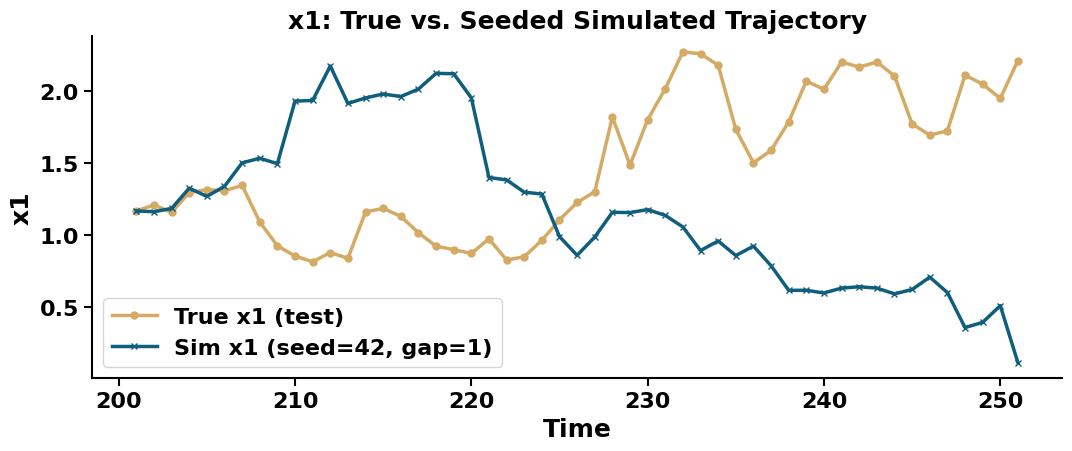

✅ Saved: out_pdf_like/plots\rollout_seeded_test_x1.png
✅ Saved: out_pdf_like/plots\rollout_seeded_test_x1.svg


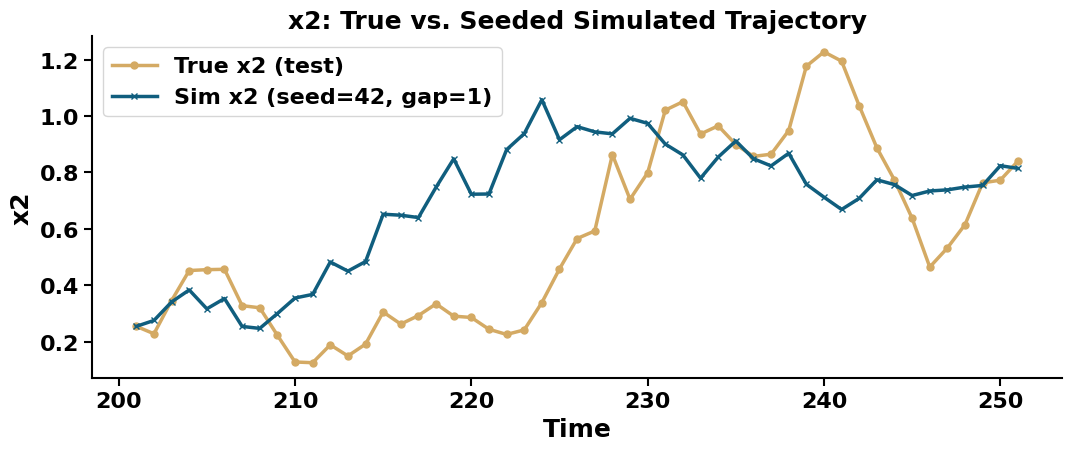

✅ Saved: out_pdf_like/plots\rollout_seeded_test_x2.png
✅ Saved: out_pdf_like/plots\rollout_seeded_test_x2.svg


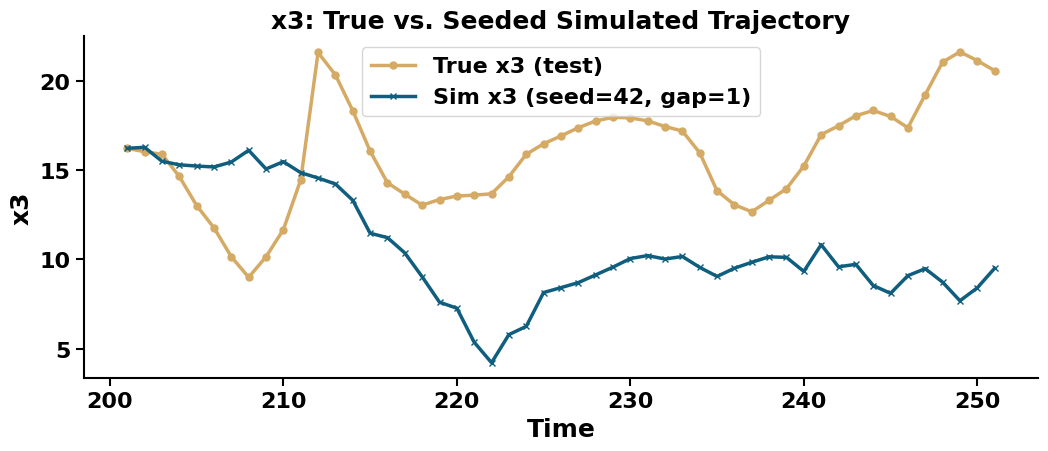

✅ Saved: out_pdf_like/plots\rollout_seeded_test_x3.png
✅ Saved: out_pdf_like/plots\rollout_seeded_test_x3.svg


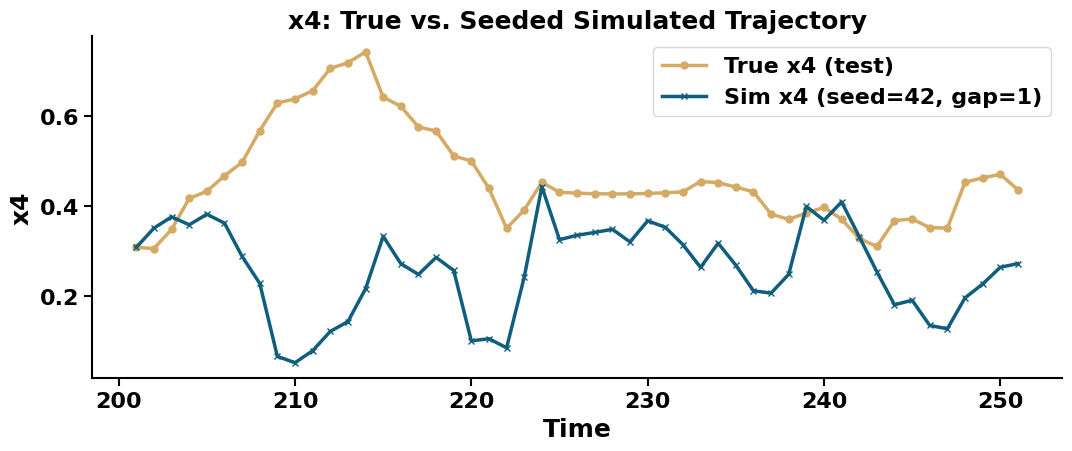

✅ Saved: out_pdf_like/plots\rollout_seeded_test_x4.png
✅ Saved: out_pdf_like/plots\rollout_seeded_test_x4.svg
✅ Done. 反复运行本 cell 会得到完全相同的仿真轨迹（同权重+同数据+同 GLOBAL_SEED）。


In [ ]:
# ==============================
# Model loading
# ==============================

import os, random, json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

# ---------- 0) seeds / determinism ----------
GLOBAL_SEED = int(os.environ.get("GLOBAL_SEED", "42"))
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

NUMBER_TYPE = tf.float64
tfd = tfp.distributions

# ---------- 0.5) 依赖检查 ----------
need = ["Numerics", "ModelBuilder", "define_sde_with_lv", "SDEApproximationNetwork", "SDEIdentification"]
for n in need:
    assert n in globals(), f"❌ 缺少依赖：{n}。请先运行训练脚本中定义这些类/函数的 cell。"

# ---------- 1) loader：一行加载（不重算 split/stats） ----------
def _meta_path_from_weight(weight_path: str) -> str:
    base, _ = os.path.splitext(weight_path)
    return base + "_meta.npz"

def _cfg_path_from_weight(weight_path: str) -> str:
    base, _ = os.path.splitext(weight_path)
    return base + "_config.json"

def _load_meta_npz(meta_path: str) -> dict:
    m = np.load(meta_path, allow_pickle=True)
    meta = {k: m[k] for k in m.files}

    def _maybe_none(a):
        a = np.asarray(a)
        return None if a.size == 0 else a

    for k in ["mu_x", "sd_x", "mu_z", "sd_z"]:
        if k in meta:
            meta[k] = _maybe_none(meta[k])

    return meta

def load_trained_bundle(cfg: dict, which: str = "best"):
    """
    ✅ 与训练 cell 配套的一行加载：
      - 自动选择 best/final 权重
      - 读取 *_meta.npz（含 idx_tr/idx_va/idx_te + 标准化统计量 + n_param）
      - 优先读取 *_config.json（训练时的 cfg 快照），防止你改了 CONFIG 之后结构不一致

    返回 dict:
      {
        "cfg","model","solver",
        "df","X","Z","T",
        "idx_tr","idx_va","idx_te",
        "mu_x","sd_x","mu_z","sd_z",
        "weights_path","meta_path","run_dir"
      }
    """
    which = which.lower().strip()
    assert which in ["best", "final"], "which 只能是 'best' 或 'final'"

    # --- 1) 定位权重文件 ---
    if which == "best":
        weights_path = cfg.get("save_best_weights_path", "")
        if not weights_path or (not os.path.exists(weights_path)):
            # best 不存在就回退 final
            weights_path = cfg.get("save_weights_path", "")
    else:
        weights_path = cfg.get("save_weights_path", "")

    assert weights_path and os.path.exists(weights_path), f"❌ 找不到权重文件：{weights_path}"
    run_dir = os.path.dirname(weights_path) if os.path.dirname(weights_path) else "."

    # --- 2) 读取 meta（split+stats，不重算） ---
    meta_path = cfg.get("meta_path", None)
    if meta_path is None:
        meta_path = _meta_path_from_weight(weights_path)
    assert os.path.exists(meta_path), f"❌ 找不到 meta 文件：{meta_path}"

    meta = _load_meta_npz(meta_path)

    # --- 3) 读取 cfg 快照（防止你改了 CONFIG 造成结构不一致） ---
    cfg_saved = None
    cfg_snap = _cfg_path_from_weight(weights_path)
    if os.path.exists(cfg_snap):
        with open(cfg_snap, "r", encoding="utf-8") as f:
            cfg_saved = json.load(f)
    else:
        # 没有快照就退回当前 cfg（不推荐）
        cfg_saved = cfg

    # --- 4) 读数据（必须与训练一致） ---
    assert "data_xlsx" in cfg_saved and os.path.exists(cfg_saved["data_xlsx"]), \
        f"❌ data_xlsx 不存在：{cfg_saved.get('data_xlsx', None)}"

    df = pd.read_excel(cfg_saved["data_xlsx"])
    step_col = cfg_saved.get("step_col", "step")
    if step_col in df.columns:
        df = df.sort_values(step_col).reset_index(drop=True)
    else:
        df[step_col] = np.arange(len(df))

    state_cols = list(cfg_saved["state_cols"])
    param_cols  = list(cfg_saved["param_cols"])

    X = df[state_cols].to_numpy(np.float64)
    Z = df[param_cols].to_numpy(np.float64)
    T = df[step_col].to_numpy(np.float64)

    # --- 5) split idx（直接用 meta，不重算） ---
    idx_tr = meta["idx_tr"].astype(np.int64)
    idx_va = meta["idx_va"].astype(np.int64)
    idx_te = meta["idx_te"].astype(np.int64)

    # sanity：meta 的 N 应与数据一致
    if "N" in meta:
        assert int(meta["N"]) == len(T), f"❌ meta.N={int(meta['N'])} 但当前数据长度={len(T)}，检查 data_xlsx 是否与训练一致"

    mu_x, sd_x = meta.get("mu_x", None), meta.get("sd_x", None)
    mu_z, sd_z = meta.get("mu_z", None), meta.get("sd_z", None)

    # --- 6) rebuild model 并 load weights ---
    Numerics.set_std_floor(cfg_saved.get("std_min_value", 1e-13))

    n_x = int(meta.get("n_x", X.shape[1]))
    n_param = int(meta.get("n_param", 2 * Z.shape[1]))  # C=[z_agg, dz]

    sde_model = define_sde_with_lv(
        n_input_dimensions=n_x,
        n_output_dimensions=n_x,
        n_layers=cfg_saved["mean_num_layers"],
        n_dim_per_layer=cfg_saved["mean_hidden_dim"],
        name="sde",
        activation=cfg_saved["mean_activation"],
        diffusivity_type=cfg_saved["diff_type"],
        dtype=NUMBER_TYPE,
        n_parameter_dimensions=n_param,
        lv_trainable=cfg_saved["lv_trainable"],
        dropout_rate=cfg_saved.get("dropout_rate", 0.0),
        l2_weight=cfg_saved.get("l2_weight", 0.0),
        seed=cfg_saved.get("seed", 42),
    )

    model = SDEApproximationNetwork(
        sde_model,
        step_size=None,
        n_parameters=n_param,
        method="euler",
        diffusivity_type=cfg_saved["diff_type"],
        gate_entropy_lambda=cfg_saved.get("gate_entropy_lambda", 0.0),
    )

    _ = model(tf.zeros((1, 1 + n_x + n_param + n_x), dtype=NUMBER_TYPE))
    model.load_weights(weights_path)

    # solver（方便复用你旧的 simulate_path_block 等）
    solver = SDEIdentification(model)

    return dict(
        cfg=cfg_saved,
        model=model,
        solver=solver,
        df=df, X=X, Z=Z, T=T,
        idx_tr=idx_tr, idx_va=idx_va, idx_te=idx_te,
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z,
        weights_path=weights_path,
        meta_path=meta_path,
        run_dir=run_dir
    )

# ---------- 2) 一行加载 ----------
bundle = load_trained_bundle(CONFIG, which="best")
full_model = bundle["model"]
solver = bundle["solver"]
X, Z, T_arr = bundle["X"], bundle["Z"], bundle["T"]
idx_tr, idx_va, idx_te = bundle["idx_tr"], bundle["idx_va"], bundle["idx_te"]
mu_x, sd_x, mu_z, sd_z = bundle["mu_x"], bundle["sd_x"], bundle["mu_z"], bundle["sd_z"]
cfg = bundle["cfg"]

print(f"✅ Bundle loaded from: {bundle['run_dir']}")
print(f"✅ Weights: {bundle['weights_path']}")
print(f"✅ Meta   : {bundle['meta_path']}")
print(f"[Time split] train_len={len(idx_tr)}, val_len={len(idx_va)}, test_len={len(idx_te)}")

# ---------- 3) 复用 C=[Z_agg, ΔZ] ----------
def aggregate_z_segment(Z_blk, t, gap, mode='mean'):
    seg = Z_blk[t:t + gap]
    if mode == 'mean':
        return seg.mean(axis=0)
    if mode == 'sum':
        return seg.sum(axis=0)
    if mode == 'last':
        return seg[-1]
    if mode == 'start':
        return seg[0]
    return seg.mean(axis=0)

# ---------- 4) seeded rollout（完全可复现） ----------
def simulate_path_block_seeded(
    model,
    X_blk, Z_blk, T_blk,
    gap=1,
    cond_mode="mean",
    diffusivity_type="diagonal",
    mu_x=None, sd_x=None,
    mu_z=None, sd_z=None,
    seed_base=42,
):
    x0 = X_blk[0].copy()
    x_curr = ((x0[None, :] - mu_x) / sd_x)[0] if (mu_x is not None) else x0.copy()

    Nblk = len(T_blk)
    steps = (Nblk - 1) // gap
    x_pred = [x_curr.copy()]
    t_pred = [T_blk[0]]

    for j in range(steps):
        t = j * gap
        if t + gap >= Nblk:
            break

        dt = float(T_blk[t + gap] - T_blk[t])

        z_agg = aggregate_z_segment(Z_blk, t, gap, cond_mode)
        dz    = Z_blk[t + gap - 1] - Z_blk[t]
        zseg  = np.concatenate([z_agg, dz], axis=0).reshape(1, -1)
        zseg  = (zseg - mu_z) / sd_z if (mu_z is not None) else zseg

        x_tf  = tf.constant(x_curr.reshape(1, -1), dtype=NUMBER_TYPE)
        z_tf  = tf.constant(zseg, dtype=NUMBER_TYPE)
        dt_tf = tf.constant([[dt]], dtype=NUMBER_TYPE)

        drift, diff = model.call_xn(x_tf, z_tf)
        approx = ModelBuilder.define_normal_distribution(x_tf, dt_tf, drift, diff, diffusivity_type)

        # 关键：为每一步提供确定性 seed
        step_seed = tf.constant([int(seed_base), int(j)], dtype=tf.int32)
        x_next = approx.sample(seed=step_seed).numpy()[0]

        x_pred.append(x_next)
        t_pred.append(T_blk[t + gap])
        x_curr = x_next

    Xsim = np.asarray(x_pred, dtype=np.float64)
    Tsim = np.asarray(t_pred, dtype=np.float64)

    if mu_x is not None:
        Xsim = Xsim * sd_x + mu_x

    return Xsim, Tsim

# ---------- 5) test rollout + plot ----------
Xtest_blk = X[idx_te]
Ztest_blk = Z[idx_te]
Ttest_blk = T_arr[idx_te]

pred, t_pred = simulate_path_block_seeded(
    model=full_model,
    X_blk=Xtest_blk,
    Z_blk=Ztest_blk,
    T_blk=Ttest_blk,
    gap=cfg["rollout_gap"],
    cond_mode=cfg["cond_mode"],
    diffusivity_type=cfg["diff_type"],
    mu_x=mu_x, sd_x=sd_x,
    mu_z=mu_z, sd_z=sd_z,
    seed_base=GLOBAL_SEED,
)

# ---------- 6) plotting ----------
AXIS_LABEL_SIZE = 18
TITLE_SIZE = 18
LEGEND_SIZE = 16
TICK_SIZE = 16
FONT_WEIGHT = "bold"

orange = (212/255, 170/255, 100/255)
blue   = (16/255, 94/255, 126/255)

plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": TICK_SIZE,
    "axes.labelweight": FONT_WEIGHT,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.5,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "xtick.direction": "out",
    "ytick.direction": "out"
})

out_dir = cfg.get("plots_dir", "out_pdf_like/plots")
os.makedirs(out_dir, exist_ok=True)

names = cfg["state_cols"]
for i, name in enumerate(names):
    fig, ax = plt.subplots(figsize=(11, 4.8))
    ax.plot(Ttest_blk, Xtest_blk[:, i],
            label=f"True {name} (test)",
            color=orange, linewidth=2.5, marker='o', markersize=5)

    ax.plot(t_pred, pred[:, i],
            label=f"Sim {name} (seed={GLOBAL_SEED}, gap={cfg['rollout_gap']})",
            color=blue, linewidth=2.5, marker='x', markersize=5)

    ax.set_xlabel("Time", fontsize=AXIS_LABEL_SIZE, weight=FONT_WEIGHT)
    ax.set_ylabel(name, fontsize=AXIS_LABEL_SIZE, weight=FONT_WEIGHT)
    ax.set_title(f"{name}: True vs. Seeded Simulated Trajectory", fontsize=TITLE_SIZE, weight=FONT_WEIGHT)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width=1.5, length=6, labelsize=TICK_SIZE)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight(FONT_WEIGHT)

    ax.legend(fontsize=LEGEND_SIZE, prop={"weight": FONT_WEIGHT})
    plt.tight_layout()

    png_path = os.path.join(out_dir, f"rollout_seeded_test_{name}.png")
    svg_path = os.path.join(out_dir, f"rollout_seeded_test_{name}.svg")
    plt.savefig(png_path, dpi=300)
    plt.savefig(svg_path, format="svg")
    plt.show()

    print(f"✅ Saved: {png_path}")
    print(f"✅ Saved: {svg_path}")

print("✅ Done. 反复运行本 cell 会得到完全相同的仿真轨迹（同权重+同数据+同 GLOBAL_SEED）。")


In [4]:
import numpy as np

def compute_pi_coverage(Qlo, Qhi, t_pred, X_true, T_true,
                        idx_tr, idx_va, idx_te, names):
    """
    计算 prediction interval (PI) 覆盖率与平均带宽。
    输入：
      Qlo, Qhi: shape [M, d] 预测区间上下界（对应 t_pred）
      t_pred:   shape [M,]   预测时间点
      X_true:   shape [N, d] 真实轨迹（对应 T_true）
      T_true:   shape [N,]   真实时间点
      idx_tr/va/te: 原始 split 的索引（在 T_true 上）
      names:    list[str]    每个维度名字
    输出：
      dict: pi_metrics[segment][name] = (coverage, mean_width)
      segment in {"overall","train","val","test"}
    """
    Qlo = np.asarray(Qlo); Qhi = np.asarray(Qhi)
    t_pred = np.asarray(t_pred).reshape(-1)
    X_true = np.asarray(X_true); T_true = np.asarray(T_true).reshape(-1)

    assert Qlo.shape == Qhi.shape, "Qlo/Qhi shape mismatch"
    assert Qlo.shape[0] == t_pred.shape[0], "Qlo rows must match t_pred length"
    d = Qlo.shape[1]
    assert X_true.shape[1] == d, "X_true dim mismatch with Qlo/Qhi"

    # ---- 对齐真实值到 t_pred ----
    # 情况1：t_pred 与 T_true 一一对应（最理想）
    aligned_direct = (len(t_pred) == len(T_true) and np.allclose(t_pred, T_true, rtol=0, atol=1e-10))

    if aligned_direct:
        X_on_pred = X_true
        # 用 idx 直接切片
        seg_masks = {
            "train": np.zeros(len(t_pred), dtype=bool),
            "val":   np.zeros(len(t_pred), dtype=bool),
            "test":  np.zeros(len(t_pred), dtype=bool),
        }
        if len(idx_tr): seg_masks["train"][np.asarray(idx_tr, dtype=int)] = True
        if len(idx_va): seg_masks["val"][np.asarray(idx_va, dtype=int)]   = True
        if len(idx_te): seg_masks["test"][np.asarray(idx_te, dtype=int)]  = True
    else:
        # 情况2：时间点不完全一致 -> 对每个维度做线性插值到 t_pred
        X_on_pred = np.zeros((len(t_pred), d), dtype=float)
        for j in range(d):
            X_on_pred[:, j] = np.interp(t_pred, T_true, X_true[:, j])

        # split 用“时间边界”来划分（假设 train/val/test 在时间上连续）
        t_tr_end = T_true[int(idx_tr[-1])] if len(idx_tr) else T_true[0]
        t_va_end = T_true[int(idx_va[-1])] if len(idx_va) else t_tr_end

        seg_masks = {
            "train": t_pred <= t_tr_end + 1e-12,
            "val":   (t_pred > t_tr_end + 1e-12) & (t_pred <= t_va_end + 1e-12) if len(idx_va) else np.zeros(len(t_pred), bool),
            "test":  t_pred > t_va_end + 1e-12,
        }

    # ---- 覆盖率与带宽 ----
    def _metrics(mask):
        out = {}
        if mask is None:
            mask = np.ones(len(t_pred), dtype=bool)
        mask = np.asarray(mask, dtype=bool)
        for j, nm in enumerate(names):
            if mask.sum() == 0:
                out[nm] = (np.nan, np.nan)
                continue
            inside = (X_on_pred[mask, j] >= Qlo[mask, j]) & (X_on_pred[mask, j] <= Qhi[mask, j])
            cov = float(np.mean(inside))
            width = float(np.mean(Qhi[mask, j] - Qlo[mask, j]))
            out[nm] = (cov, width)
        return out

    pi_metrics = {
        "overall": _metrics(None),
        "train":   _metrics(seg_masks["train"]),
        "val":     _metrics(seg_masks["val"]),
        "test":    _metrics(seg_masks["test"]),
    }
    return pi_metrics


[Time split] train_len=170, val_len=30, test_len=51
[flags] val_cross_pairs=True | use_test_pairs=False | test_cross_pairs=True
[MAXG] max_gap=169
[Pairs for stats] train_pairs=14365 (gaps_used=1..169)
✅ Loaded weights from: data/resnetdz1111_best1.h5


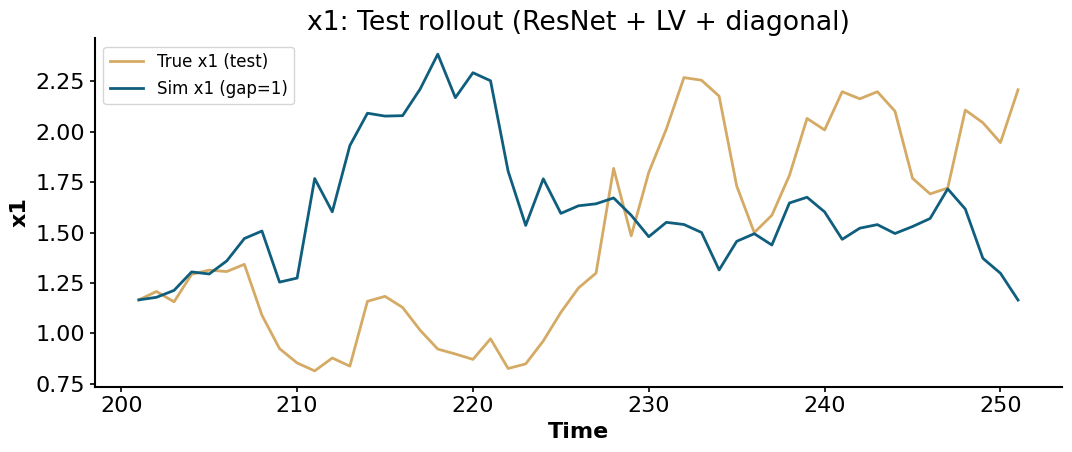

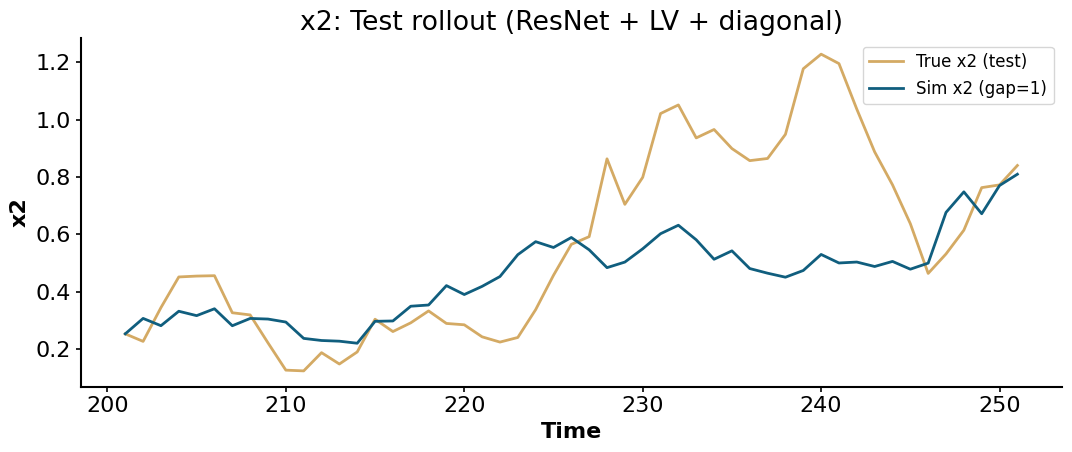

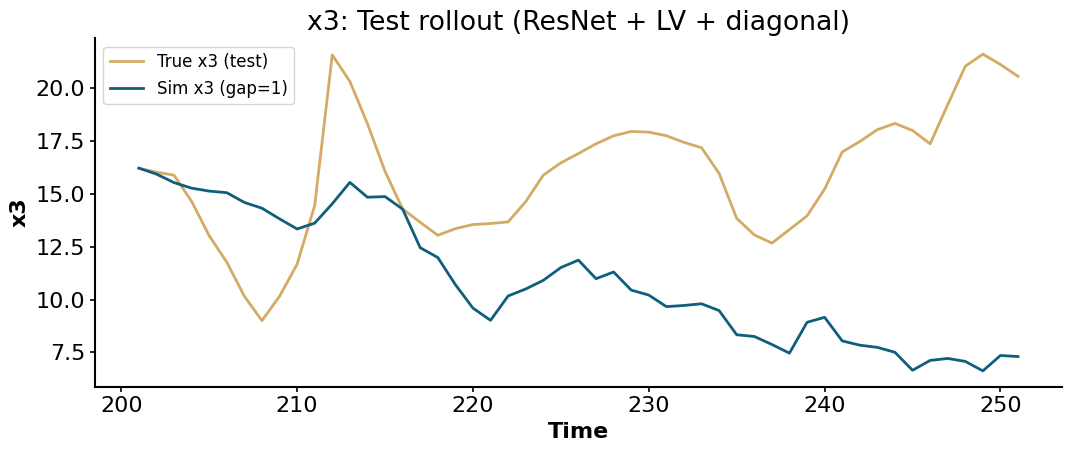

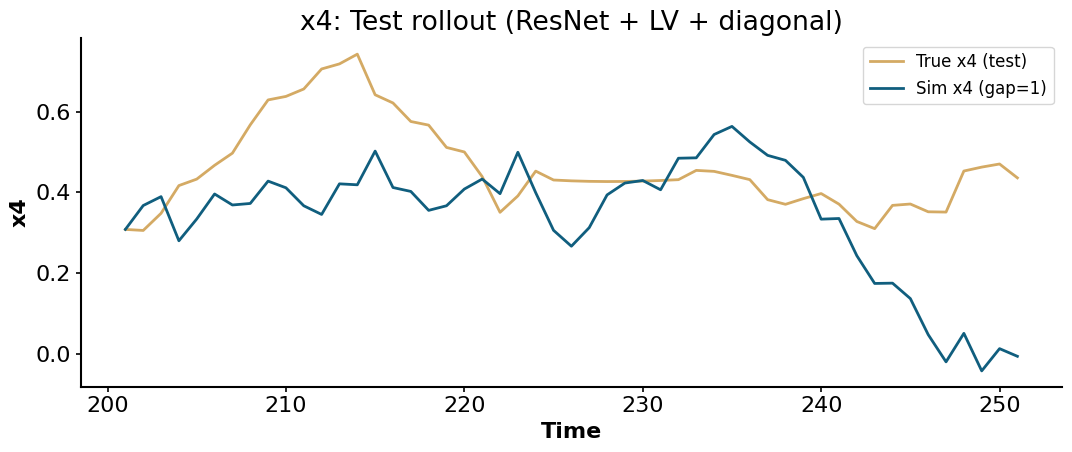

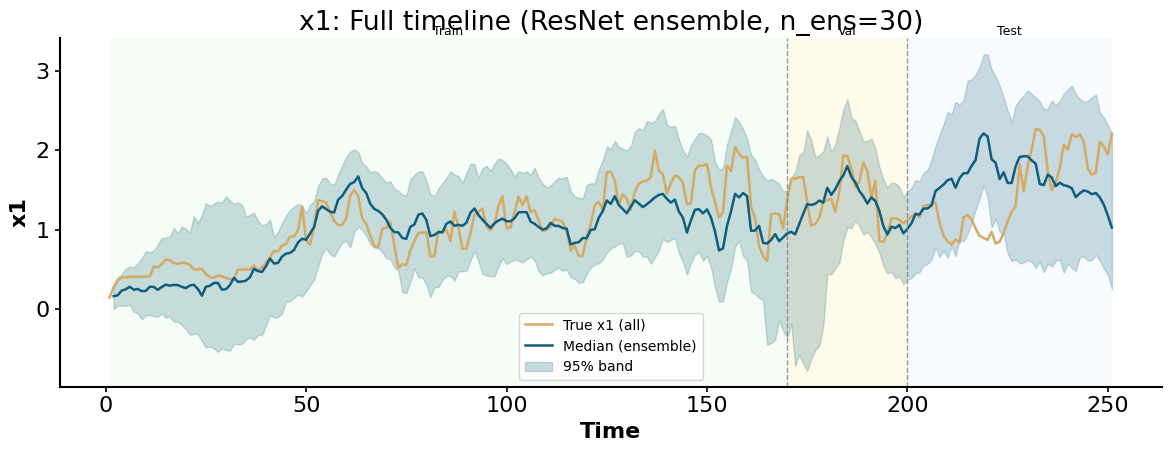

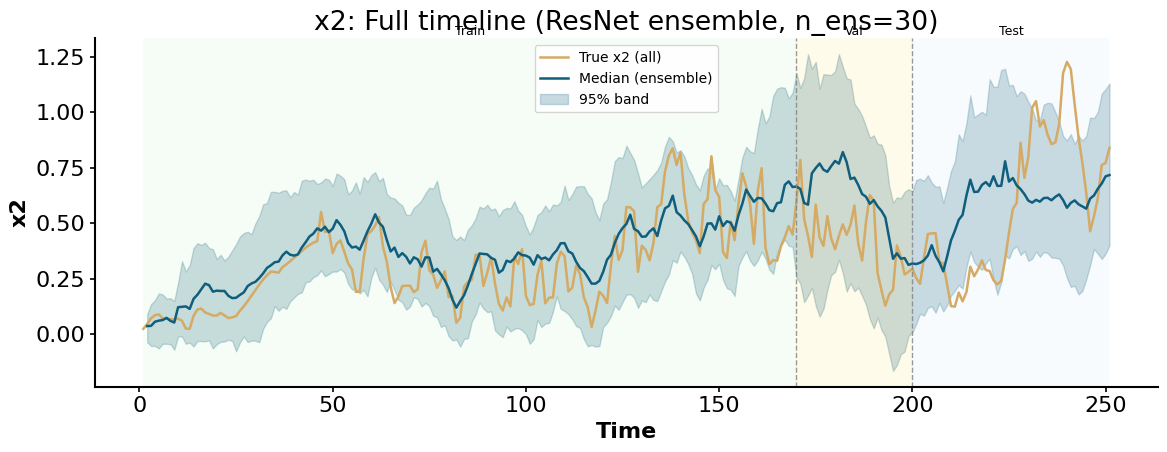

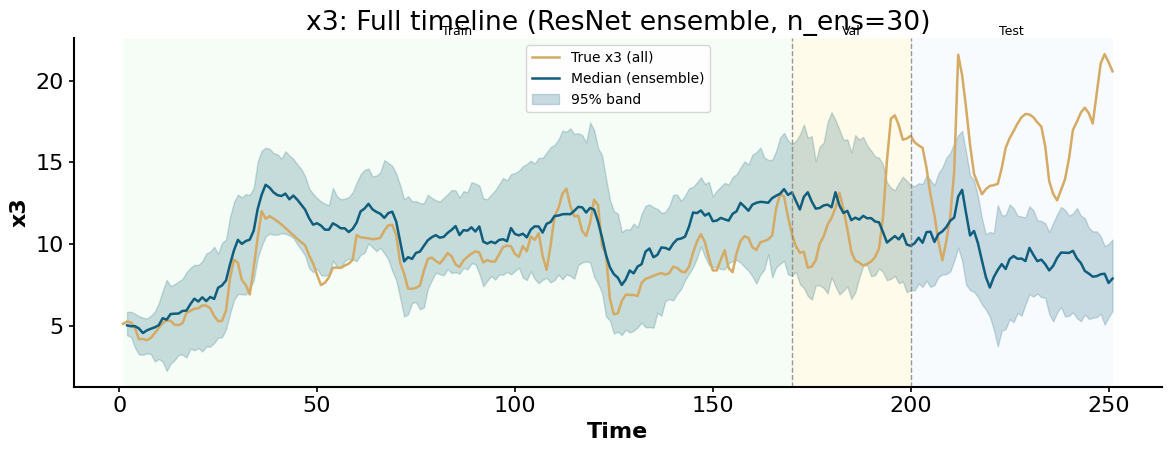

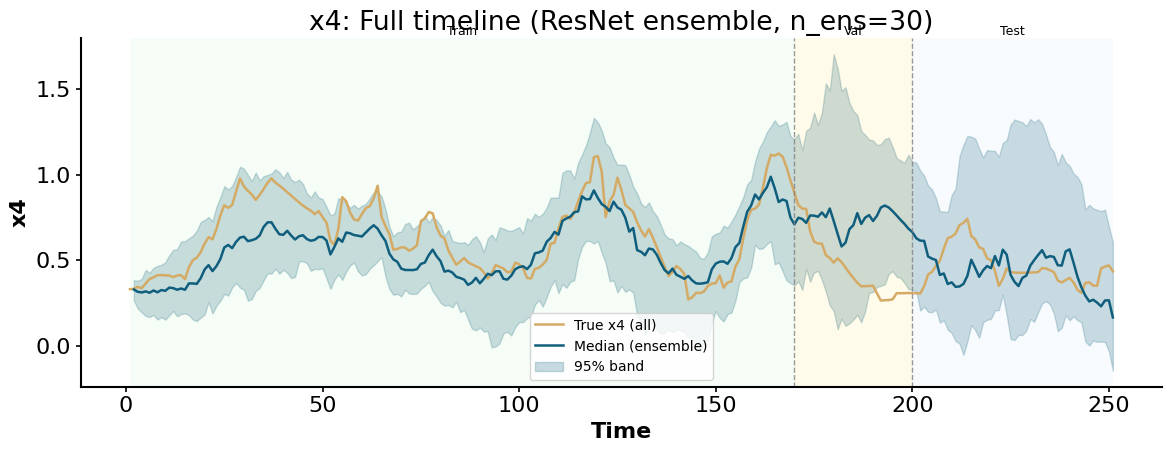


[95% band coverage] overall (希望接近 0.95)：
  x1: coverage=0.960, mean width=1.4265
  x2: coverage=0.904, mean width=0.5736
  x3: coverage=0.736, mean width=6.0879
  x4: coverage=0.932, mean width=0.6643

[95% band coverage] by segment:
  -- Train --
    x1: cov=0.994, width=1.2676
    x2: cov=0.964, width=0.4912
    x3: cov=0.911, width=5.7241
    x4: cov=0.964, width=0.5257
  -- Val --
    x1: cov=1.000, width=1.6515
    x2: cov=1.000, width=0.8682
    x3: cov=0.767, width=8.1403
    x4: cov=0.667, width=0.9871
  -- Test --
    x1: cov=0.824, width=1.8210
    x2: cov=0.647, width=0.6734
    x3: cov=0.137, width=6.0862
    x4: cov=0.980, width=0.9337

[LV drift contribution] mean E[||LV||^2 / ||total||^2] on test (gap=1) = 0.395
  dim x1: mean |LV| / (|LV|+|ResNet|) ≈ 0.341
  dim x2: mean |LV| / (|LV|+|ResNet|) ≈ 0.198
  dim x3: mean |LV| / (|LV|+|ResNet|) ≈ 0.568
  dim x4: mean |LV| / (|LV|+|ResNet|) ≈ 0.298


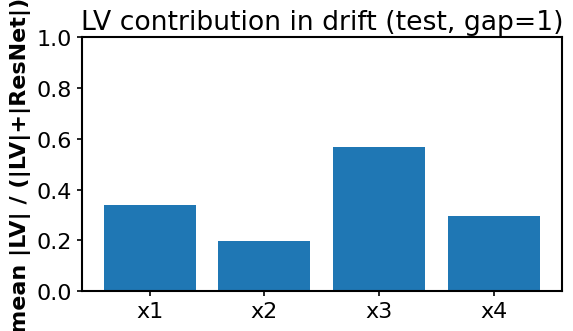

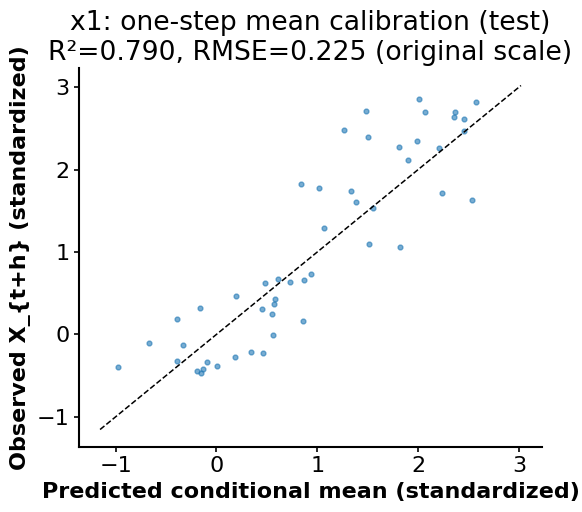

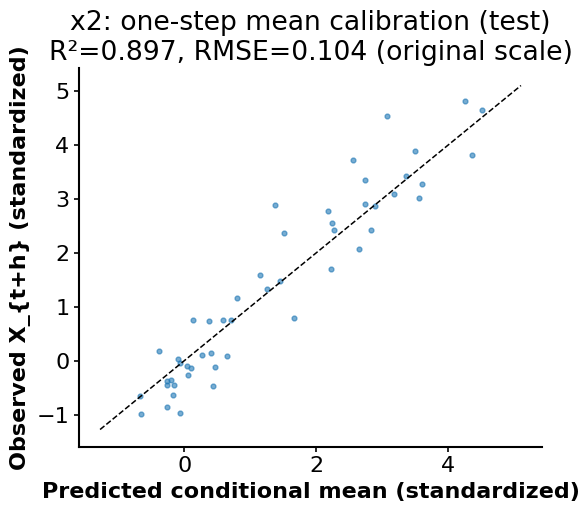

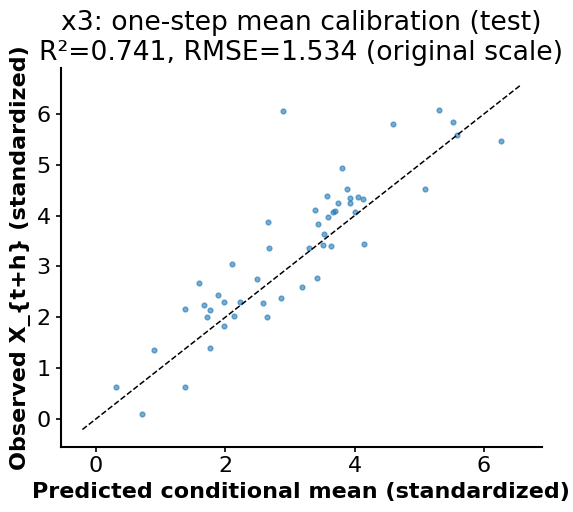

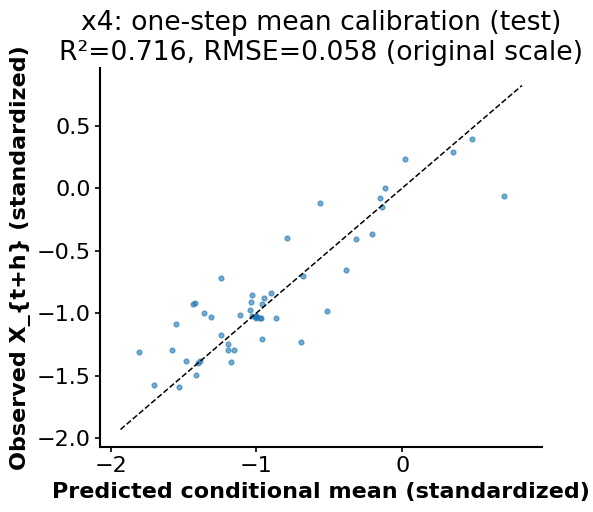

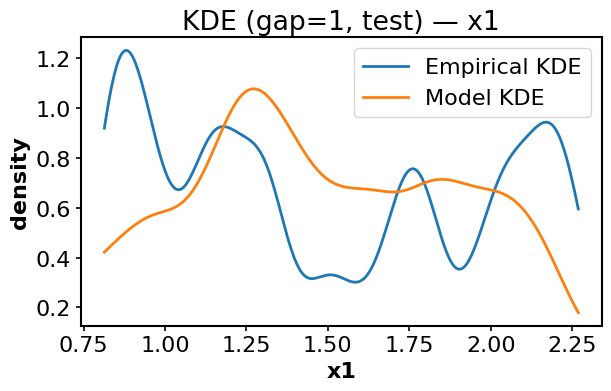

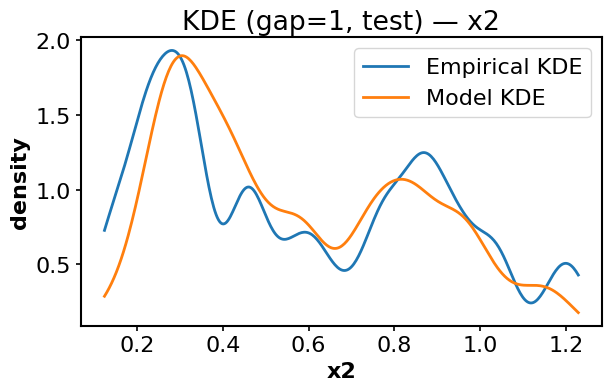

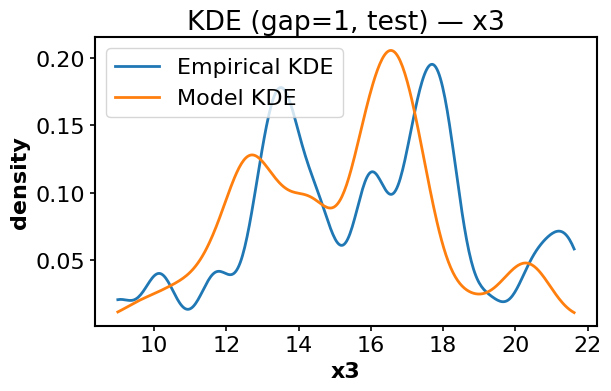

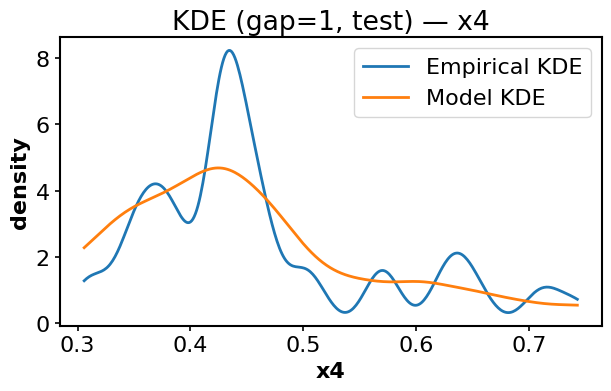

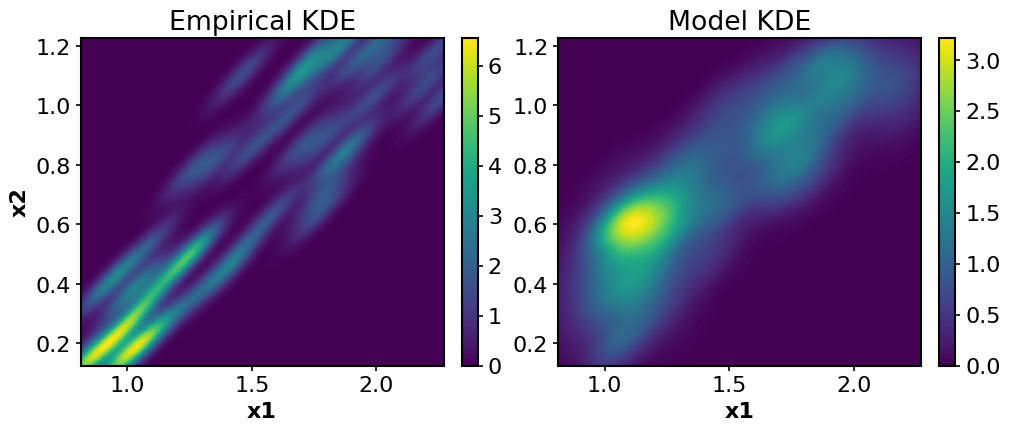

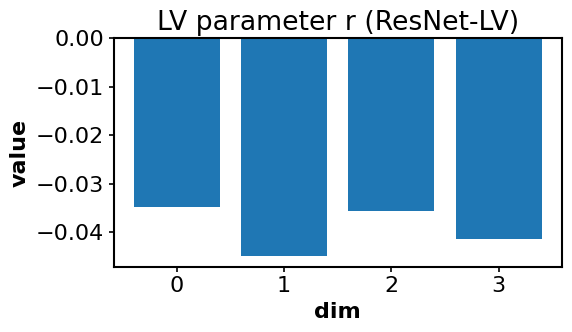

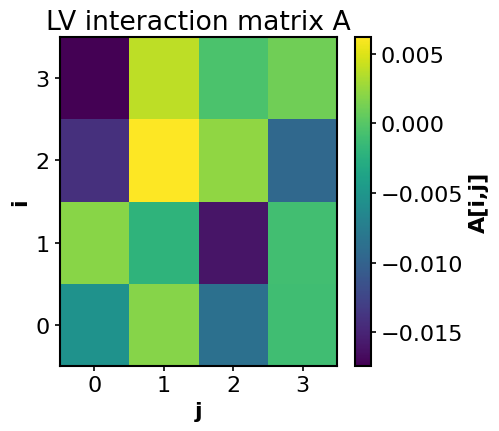


✅ Done drawing all figures & diagnostics (no files saved).


In [5]:
# ========================== Cell: PLOTS & Diagnostics (ResNet+LV，多间隔) [FIXED] ==========================
import os, gc, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import tensorflow as tf
import keras
import keras.backend as K

tf.keras.backend.set_floatx('float64')
NUMBER_TYPE = tf.float64
np.set_printoptions(suppress=True, precision=6)

# ---------- 依赖检查（确保你训练脚本里定义过这些） ----------
need_names = [
    "Numerics", "ModelBuilder", "define_sde_with_lv", "SDEApproximationNetwork",
    "SDEIdentification", "aggregate_z_segment", "build_multi_h_pairs_on_block",
    "simulate_path_block", "generate_sde_time_series"
]
for n in need_names:
    assert n in globals(), f"❌ 缺少依赖：{n}。请先运行训练脚本里定义这些类/函数的 cell。"

# ---------- 小工具 ----------
def acf_1d(x, nlags=40):
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    denom = np.dot(x, x) + 1e-18
    ac = [1.0]
    for k in range(1, nlags+1):
        ac.append(float(np.dot(x[:-k], x[k:]) / denom))
    return np.array(ac)

def rmse(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    return float(np.sqrt(np.mean((a - b)**2)))

def r2(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    ss_res = np.sum((a - b)**2)
    ss_tot = np.sum((b - b.mean())**2) + 1e-18
    return float(1.0 - ss_res / ss_tot)

# ---------- KDE 工具（1D + 2D，高斯核） ----------
def _kde_pdf_1d(x, grid=None, bw="scott"):
    x = np.asarray(x).ravel()
    if np.std(x) < 1e-12:
        mu = float(np.mean(x))
        sd = 1e-6
        if grid is None:
            grid = np.linspace(mu-5*sd, mu+5*sd, 400)
        pdf = (1/np.sqrt(2*np.pi*sd*sd)) * np.exp(-0.5*((grid-mu)/sd)**2)
        pdf /= (np.trapz(pdf, grid) + 1e-18)
        return grid, pdf
    kde = gaussian_kde(x, bw_method=bw)
    if grid is None:
        gmin, gmax = np.percentile(x, [0.5, 99.5])
        grid = np.linspace(gmin, gmax, 400)
    pdf = kde(grid)
    pdf /= (np.trapz(pdf, grid) + 1e-18)
    return grid, pdf

def _kde_pdf_2d(xy, grids=160, bw="scott"):
    xy = np.asarray(xy, dtype=np.float64)
    if np.std(xy[:,0]) < 1e-12 or np.std(xy[:,1]) < 1e-12:
        xy = xy + np.random.normal(0.0, 1e-6, size=xy.shape)
    kde = gaussian_kde(xy.T, bw_method=bw)
    x_min, x_max = np.percentile(xy[:,0], [0.5, 99.5])
    y_min, y_max = np.percentile(xy[:,1], [0.5, 99.5])
    xs = np.linspace(x_min, x_max, grids)
    ys = np.linspace(y_min, y_max, grids)
    Xg, Yg = np.meshgrid(xs, ys, indexing="xy")
    pts = np.vstack([Xg.ravel(), Yg.ravel()])
    Z = kde(pts).reshape(grids, grids)
    Z /= (np.trapz(np.trapz(Z, xs, axis=1), ys, axis=0) + 1e-18)
    return xs, ys, Z

def kde_plots_show(model, X_blk, Z_blk, T_blk, names,
                   mu_x=None, sd_x=None, mu_z=None, sd_z=None,
                   cond_mode="mean", n_sims=400, bw="scott",
                   diff_type="diagonal"):
    """
    Test 段 gap=1 的条件分布 KDE 对比；条件输入采用 C=[Z_agg, ΔZ]。
    """
    avail = len(X_blk) - 1
    if avail <= 0:
        print("⚠️ 块长度太短，无法做 KDE。")
        return

    idx = np.arange(avail)
    h  = (T_blk[idx + 1] - T_blk[idx]).reshape(-1,1)
    xn = X_blk[idx]
    xp = X_blk[idx + 1]

    # gap=1: C=[Z_agg, ΔZ]，ΔZ=0（但维度一致）
    C_rows = []
    for t in idx:
        z_agg = aggregate_z_segment(Z_blk, t, 1, cond_mode)
        dz    = Z_blk[t] - Z_blk[t]
        C_rows.append(np.concatenate([z_agg, dz], axis=0))
    z = np.vstack(C_rows).astype(np.float64)

    xn_s = (xn - mu_x) / sd_x if mu_x is not None else xn
    xp_s = (xp - mu_x) / sd_x if mu_x is not None else xp
    z_s  = (z  - mu_z) / sd_z if mu_z is not None else z

    S = int(n_sims)
    xn_rep = np.repeat(xn_s, S, axis=0)
    z_rep  = np.repeat(z_s,  S, axis=0)
    h_rep  = np.repeat(h,    S, axis=0)

    # 全部转 tensor，避免 numpy/tensor 混用
    xn_tf = tf.convert_to_tensor(xn_rep, dtype=NUMBER_TYPE)
    z_tf  = tf.convert_to_tensor(z_rep,  dtype=NUMBER_TYPE)
    h_tf  = tf.convert_to_tensor(h_rep,  dtype=NUMBER_TYPE)

    # model.call_xn 支持 (x, param)
    mu_hat, sig_hat = model.call_xn(xn_tf, z_tf)
    approx = ModelBuilder.define_normal_distribution(xn_tf, h_tf, mu_hat, sig_hat, diff_type)
    x_samp = approx.sample().numpy()

    pred_all = x_samp * sd_x + mu_x if mu_x is not None else x_samp
    true_all = np.repeat(xp, S, axis=0)

    # 1D
    for i, nm in enumerate(names):
        g_true, p_true = _kde_pdf_1d(true_all[:,i], bw=bw)
        g_pred, p_pred = _kde_pdf_1d(pred_all[:,i], grid=g_true, bw=bw)
        plt.figure(figsize=(6.4,4.2))
        plt.plot(g_true, p_true, label="Empirical KDE", lw=2.0)
        plt.plot(g_pred, p_pred, label="Model KDE", lw=2.0)
        plt.title(f"KDE (gap=1, test) — {nm}")
        plt.xlabel(nm); plt.ylabel("density"); plt.legend()
        plt.tight_layout(); plt.show()

    # 2D（只画前两维）
    if len(names) >= 2:
        xs, ys, Zt = _kde_pdf_2d(true_all[:, :2], grids=160, bw=bw)
        _,  _, Zp  = _kde_pdf_2d(pred_all[:, :2], grids=160, bw=bw)
        fig, ax = plt.subplots(1,2,figsize=(10,4.2), constrained_layout=True)
        im0 = ax[0].imshow(Zt.T, origin="lower",
                           extent=[xs.min(), xs.max(), ys.min(), ys.max()], aspect="auto")
        ax[0].set_title("Empirical KDE"); fig.colorbar(im0, ax=ax[0])
        im1 = ax[1].imshow(Zp.T, origin="lower",
                           extent=[xs.min(), xs.max(), ys.min(), ys.max()], aspect="auto")
        ax[1].set_title("Model KDE");    fig.colorbar(im1, ax=ax[1])
        for a in ax: a.set_xlabel(names[0])
        ax[0].set_ylabel(names[1])
        plt.show()

# ---------- ensemble rollout（加裁剪防爆炸） ----------
def simulate_path_block_ensemble(model, X_blk, Z_blk, T_blk,
                                 gap=1, cond_mode='mean',
                                 mu_x=None, sd_x=None, mu_z=None, sd_z=None,
                                 diff_type="diagonal", n_ens=30,
                                 quantiles=(0.025,0.5,0.975),
                                 clip_std=5.0):
    """
    从块第一个点出发，ensemble 滚动：
    - 条件输入 C = [Z_agg, ΔZ]
    - 在标准化空间做 clip 防爆炸
    返回：Qlo/Qmd/Qhi shape=(K, d), t_axis shape=(K,)
    """
    X0 = X_blk[0].copy()
    X0s = ((X0[None,:]-mu_x)/sd_x)[0] if (mu_x is not None) else X0.copy()

    Nblk = len(T_blk)
    steps = (Nblk - 1)//gap
    n_ens = int(n_ens)

    ens = np.tile(X0s[None,:], (n_ens, 1)).astype(np.float64)
    traj = [ens.copy()]
    t_axis = [T_blk[0]]

    for j in range(steps):
        t = j*gap
        if t + gap >= Nblk: break
        dt = float(T_blk[t+gap] - T_blk[t])

        z_agg = aggregate_z_segment(Z_blk, t, gap, cond_mode)
        dz    = Z_blk[t+gap-1] - Z_blk[t]
        zseg  = np.concatenate([z_agg, dz]).reshape(1,-1).astype(np.float64)
        zseg_s = (zseg - mu_z) / sd_z if (mu_z is not None) else zseg
        zseg_rep = np.repeat(zseg_s, n_ens, axis=0)

        x_n_np = traj[-1].astype(np.float64)

        x_n = tf.convert_to_tensor(x_n_np, dtype=NUMBER_TYPE)
        z_r = tf.convert_to_tensor(zseg_rep, dtype=NUMBER_TYPE)
        h_r = tf.convert_to_tensor(np.ones((n_ens,1), dtype=np.float64)*dt, dtype=NUMBER_TYPE)

        mu_hat, sig_hat = model.call_xn(x_n, z_r)
        approx = ModelBuilder.define_normal_distribution(x_n, h_r, mu_hat, sig_hat, diff_type)
        x_np1 = approx.sample().numpy()

        x_np1 = np.clip(x_np1, -clip_std, clip_std)
        traj.append(x_np1)
        t_axis.append(T_blk[t+gap])

    traj_arr = np.stack(traj, axis=1)  # (S, steps+1, d)
    if mu_x is not None:
        traj_arr = traj_arr * sd_x + mu_x

    traj_no0 = traj_arr[:,1:,:]  # (S, K, d)
    qs = {q: np.quantile(traj_no0, q, axis=0) for q in quantiles}
    return qs[0.025], qs[0.5], qs[0.975], np.array(t_axis[1:], dtype=np.float64)

# ---------- 置信区间覆盖率 & 带宽 ----------
def compute_pi_coverage(Qlo, Qhi, t_axis, X, T, idx_tr, idx_va, idx_te, names):
    T = np.asarray(T)
    idx_tr = np.asarray(idx_tr)
    idx_va = np.asarray(idx_va)
    idx_te = np.asarray(idx_te)

    idx_map = []
    for tt in t_axis:
        idx_exact = np.where(np.isclose(T, tt, rtol=1e-10, atol=1e-10))[0]
        if len(idx_exact) > 0:
            idx_map.append(idx_exact[0])
        else:
            idx_map.append(int(np.argmin(np.abs(T - tt))))
    idx_map = np.array(idx_map, dtype=int)

    seg_tr = np.isin(idx_map, idx_tr)
    seg_va = np.isin(idx_map, idx_va)
    seg_te = np.isin(idx_map, idx_te)

    metrics = {"overall": {}, "train": {}, "val": {}, "test": {}}

    for j, nm in enumerate(names):
        lo = Qlo[:, j]
        hi = Qhi[:, j]
        x  = X[idx_map, j]
        inside = (x >= lo) & (x <= hi)
        width  = hi - lo

        def _cov_w(mask):
            if mask is None:
                m = np.ones_like(inside, dtype=bool)
            else:
                m = mask
            if not np.any(m):
                return np.nan, np.nan
            cov = float(inside[m].mean())
            w   = float(width[m].mean())
            return cov, w

        metrics["overall"][nm] = _cov_w(None)
        metrics["train"][nm]   = _cov_w(seg_tr)
        metrics["val"][nm]     = _cov_w(seg_va)
        metrics["test"][nm]    = _cov_w(seg_te)

    return metrics

# ---------- 主入口：只画图（不训练） ----------
def plots_only_show(cfg, n_ens=30):
    plt.close('all')
    tf.keras.backend.clear_session()
    gc.collect()

    np.random.seed(cfg["seed"])
    tf.random.set_seed(cfg["seed"])
    Numerics.set_std_floor(cfg.get("std_min_value", 1e-13))

    # ===== 1) 读数据 =====
    if cfg["use_synthetic"] or (not os.path.exists(cfg["data_xlsx"])):
        df = generate_sde_time_series(
            total_steps=cfg["synthetic_total_steps"],
            step_size=cfg["synthetic_dt"],
            mutation_step=cfg["synthetic_mutation_step"],
            out_path=cfg["synthetic_out_path"],
            seed=cfg["seed"]
        )
    else:
        df = pd.read_excel(cfg["data_xlsx"])

    step_col = cfg["step_col"]
    if step_col in df.columns:
        df = df.sort_values(step_col).reset_index(drop=True)
    else:
        df[step_col] = np.arange(len(df))

    if "Z2" in df.columns and ("Z2_log" in cfg["param_cols"]):
        df["Z2_log"] = np.log1p(df["Z2"])

    X = df[cfg["state_cols"]].to_numpy(np.float64)
    Z = df[cfg["param_cols"]].to_numpy(np.float64)
    T = df[step_col].to_numpy(np.float64) if step_col in df.columns else np.arange(len(df), dtype=np.float64)

    N = len(T); n_x = X.shape[1]; n_z = Z.shape[1]

    # ===== 2) 时间切分：严格按训练脚本逻辑（关键修复） =====
    R_TR, R_VA, R_TE = cfg["split_ratios"]
    MAXG = max(cfg["gaps"])

    split_tr = int(N * R_TR)
    split_va = int(N * (R_TR + R_VA))

    # train 段内训练一定要 > MAXG
    if split_tr <= MAXG:
        split_tr = MAXG + 1

    # val：只有在 val 段内配对时才需要 > MAXG
    if (not cfg.get("val_cross_pairs", True)) and (split_va - split_tr <= MAXG):
        split_va = split_tr + (MAXG + 1)

    # ✅ test 不做 pairs 时，不用 MAXG 约束 test_len
    if cfg.get("use_test_pairs", True):
        if (not cfg.get("test_cross_pairs", True)) and (N - split_va <= MAXG):
            split_va = N - (MAXG + 1)

    # 兜底
    split_tr = int(np.clip(split_tr, 1, N - 1))
    split_va = int(np.clip(split_va, split_tr + 1, N))

    idx_tr = np.arange(0, split_tr)
    idx_va = np.arange(split_tr, split_va)
    idx_te = np.arange(split_va, N)

    print(f"[Time split] train_len={len(idx_tr)}, val_len={len(idx_va)}, test_len={len(idx_te)}")
    print(f"[flags] val_cross_pairs={cfg.get('val_cross_pairs', True)} | "
          f"use_test_pairs={cfg.get('use_test_pairs', True)} | test_cross_pairs={cfg.get('test_cross_pairs', True)}")
    print(f"[MAXG] max_gap={MAXG}")

    rng = np.random.default_rng(cfg["seed"])

    # ===== 3) 标准化统计量：只用 Train pairs（避免 val/test block 太短报错） =====
    gaps_train = [g for g in cfg["gaps"] if g < len(idx_tr)]
    if len(gaps_train) == 0:
        raise RuntimeError(
            f"train_len={len(idx_tr)} 太短，cfg['gaps']={min(cfg['gaps'])}..{max(cfg['gaps'])} 全不可用。"
            f"请减小 gaps 或增加训练段长度。"
        )

    Xn_tr, Xnp1_tr, C_tr, H_tr = build_multi_h_pairs_on_block(
        X[idx_tr], Z[idx_tr], T[idx_tr],
        gaps_train, cfg["max_per_gap"], cfg["cond_mode"], rng=rng
    )
    print(f"[Pairs for stats] train_pairs={len(Xn_tr)} (gaps_used={min(gaps_train)}..{max(gaps_train)})")

    # 统计量
    def fit_stats_local(arr):
        mu = arr.mean(axis=0, keepdims=True)
        sd = arr.std(axis=0, keepdims=True) + 1e-12
        return mu, sd

    if cfg["standardize_x"]:
        mu_x, sd_x = fit_stats_local(np.vstack([Xn_tr, Xnp1_tr]))
    else:
        mu_x = sd_x = None

    if cfg["standardize_z"]:
        mu_z, sd_z = fit_stats_local(C_tr)
    else:
        mu_z = sd_z = None

    # ===== 4) 重建模型 & 加载权重 =====
    sde_core = define_sde_with_lv(
        n_input_dimensions=n_x,
        n_output_dimensions=n_x,
        n_layers=cfg["mean_num_layers"],
        n_dim_per_layer=cfg["mean_hidden_dim"],
        name="sde",
        activation=cfg["mean_activation"],
        diffusivity_type=cfg["diff_type"],
        dtype=NUMBER_TYPE,
        n_parameter_dimensions=C_tr.shape[1],   # 2*n_z
        lv_trainable=cfg["lv_trainable"],
        dropout_rate=cfg.get("dropout_rate", 0.05),
        l2_weight=cfg.get("l2_weight", 1e-4),
        seed=cfg["seed"]
    )

    full_model = SDEApproximationNetwork(
        sde_core,
        step_size=None,
        n_parameters=C_tr.shape[1],
        method="euler",
        diffusivity_type=cfg["diff_type"],
        gate_entropy_lambda=cfg.get("gate_entropy_lambda", 0.0)
    )

    # build
    dummy_cols = 1 + n_x + C_tr.shape[1] + n_x
    _ = full_model(tf.zeros((1, dummy_cols), dtype=NUMBER_TYPE))

    # LV 拆分子模型（可选）
    lv_res_model = None
    try:
        lv_res_model = tf.keras.Model(
            inputs=sde_core.inputs,
            outputs=[
                sde_core.get_layer("sde_lv_prior").output,
                sde_core.get_layer("sde_mean_res_out").output,
            ],
            name="sde_lv_resplit"
        )
    except Exception as e:
        print("⚠️ 无法构造 LV 拆分子模型，跳过 LV 贡献分析：", e)

    # 找权重（best 优先）
    cand_paths = [cfg.get("save_best_weights_path", ""), cfg.get("save_weights_path", "")]
    weight_path = None
    for p in cand_paths:
        if p and os.path.exists(p):
            weight_path = p
            break
    if weight_path is None:
        raise FileNotFoundError(f"❌ 找不到权重文件，候选：{cand_paths}")

    full_model.load_weights(weight_path)
    print(f"✅ Loaded weights from: {weight_path}")

    # 创建 solver（用于 simulate_path_block）
    solver = SDEIdentification(full_model)

    names = cfg["state_cols"]
    orange=(212/255,170/255,100/255); blue=(16/255,94/255,126/255)

    # ===== 5) Test 段单路径 rollout =====
    X_te_blk, Z_te_blk, T_te_blk = X[idx_te], Z[idx_te], T[idx_te]
    pred_single, t_single = simulate_path_block(
        solver, X_te_blk, Z_te_blk, T_te_blk,
        gap=cfg["rollout_gap"], cond_mode=cfg["cond_mode"],
        diffusivity_type=cfg["diff_type"],
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z
    )

    for i, name in enumerate(names):
        fig, ax = plt.subplots(figsize=(11,4.8))
        ax.plot(T_te_blk, X_te_blk[:,i], label=f"True {name} (test)", color=orange, lw=2.0)
        ax.plot(t_single, pred_single[:,i],
                label=f"Sim {name} (gap={cfg['rollout_gap']})", color=blue, lw=2.0)
        ax.set_xlabel("Time"); ax.set_ylabel(name)
        ax.set_title(f"{name}: Test rollout (ResNet + LV + {cfg['diff_type']})")
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.legend(fontsize=12)
        plt.tight_layout(); plt.show()

    # ===== 6) 全时序 ensemble（train+val+test） =====
    Qlo_all, Qmd_all, Qhi_all, t_all = simulate_path_block_ensemble(
        full_model, X, Z, T,
        gap=cfg["rollout_gap"], cond_mode=cfg["cond_mode"],
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z,
        diff_type=cfg["diff_type"], n_ens=n_ens, quantiles=(0.025,0.5,0.975),
        clip_std=5.0
    )

    t_tr_end = T[idx_tr[-1]]
    t_va_end = T[idx_va[-1]]

    for i, name in enumerate(names):
        fig, ax = plt.subplots(figsize=(12,4.8))
        ax.plot(T, X[:,i], color=orange, lw=1.8, label=f"True {name} (all)")
        ax.plot(t_all, Qmd_all[:,i], color=blue, lw=1.8, label="Median (ensemble)")
        ax.fill_between(t_all, Qlo_all[:,i], Qhi_all[:,i], alpha=0.22, color=blue, label="95% band")

        ax.axvline(t_tr_end, ls="--", lw=1.0, color="gray", alpha=0.8)
        ax.axvline(t_va_end, ls="--", lw=1.0, color="gray", alpha=0.8)

        ymin, ymax = ax.get_ylim()
        ax.axvspan(T[0],      t_tr_end, facecolor="lightgreen", alpha=0.08)
        ax.axvspan(t_tr_end,  t_va_end, facecolor="gold",       alpha=0.08)
        ax.axvspan(t_va_end,  T[-1],    facecolor="lightblue",  alpha=0.08)

        ax.text((T[0]+t_tr_end)/2, ymax, "Train", va="bottom", ha="center", fontsize=9)
        ax.text((t_tr_end+t_va_end)/2, ymax, "Val", va="bottom", ha="center", fontsize=9)
        ax.text((t_va_end+T[-1])/2, ymax, "Test", va="bottom", ha="center", fontsize=9)

        ax.set_xlabel("Time"); ax.set_ylabel(name)
        ax.set_title(f"{name}: Full timeline (ResNet ensemble, n_ens={n_ens})")
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.legend(fontsize=10)
        plt.tight_layout(); plt.show()

    # 覆盖率
    pi_metrics = compute_pi_coverage(Qlo_all, Qhi_all, t_all, X, T, idx_tr, idx_va, idx_te, names)
    print("\n[95% band coverage] overall (希望接近 0.95)：")
    for nm in names:
        cov, w = pi_metrics["overall"][nm]
        print(f"  {nm}: coverage={cov:.3f}, mean width={w:.4f}")

    print("\n[95% band coverage] by segment:")
    for seg_key, seg_name in [("train","Train"), ("val","Val"), ("test","Test")]:
        print(f"  -- {seg_name} --")
        for nm in names:
            cov, w = pi_metrics[seg_key][nm]
            if np.isnan(cov):
                print(f"    {nm}: no points")
            else:
                print(f"    {nm}: cov={cov:.3f}, width={w:.4f}")

    # ===== 7) Test 段一步均值校准（gap=1） + LV 贡献 =====
    avail = len(X_te_blk) - 1
    if avail > 0:
        idx_step = np.arange(avail)
        h1  = (T_te_blk[idx_step+1] - T_te_blk[idx_step]).reshape(-1,1)
        xn1 = X_te_blk[idx_step]
        xp1 = X_te_blk[idx_step+1]

        # gap=1: C=[Z_agg, ΔZ]，ΔZ=0
        C_rows = []
        for t in idx_step:
            z_agg = aggregate_z_segment(Z_te_blk, t, 1, cfg["cond_mode"])
            dz    = Z_te_blk[t] - Z_te_blk[t]
            C_rows.append(np.concatenate([z_agg, dz], axis=0))
        z1 = np.vstack(C_rows).astype(np.float64)

        xn1_s = (xn1 - mu_x)/sd_x if mu_x is not None else xn1
        xp1_s = (xp1 - mu_x)/sd_x if mu_x is not None else xp1
        z1_s  = (z1  - mu_z)/sd_z if mu_z is not None else z1

        xn_tf = tf.convert_to_tensor(xn1_s, dtype=NUMBER_TYPE)
        z_tf  = tf.convert_to_tensor(z1_s,  dtype=NUMBER_TYPE)

        mu1, sig1 = full_model.call_xn(xn_tf, z_tf)   # drift, diff
        mu1 = mu1.numpy()
        loc = xn1_s + h1 * mu1  # 条件均值（标准化空间）

        # LV vs ResNet 贡献（drift）
        if lv_res_model is not None:
            inp_gap1 = np.concatenate([xn1_s, z1_s], axis=1)
            lv_dr, res_dr = lv_res_model(tf.convert_to_tensor(inp_gap1, dtype=NUMBER_TYPE))
            lv_dr = lv_dr.numpy()
            res_dr = res_dr.numpy()
            tot_dr = lv_dr + res_dr

            num = np.sum(lv_dr**2, axis=1)
            den = np.sum(tot_dr**2, axis=1) + 1e-12
            frac_lv_global = float(np.mean(num / den))
            print(f"\n[LV drift contribution] mean E[||LV||^2 / ||total||^2] on test (gap=1) = {frac_lv_global:.3f}")

            mean_lv_abs  = np.mean(np.abs(lv_dr), axis=0)
            mean_res_abs = np.mean(np.abs(res_dr), axis=0)
            frac_dim = mean_lv_abs / (mean_lv_abs + mean_res_abs + 1e-12)
            for j, nm in enumerate(names):
                print(f"  dim {nm}: mean |LV| / (|LV|+|ResNet|) ≈ {frac_dim[j]:.3f}")

            fig, ax = plt.subplots(figsize=(6.0,3.6))
            ax.bar(np.arange(len(names)), frac_dim)
            ax.set_xticks(np.arange(len(names)))
            ax.set_xticklabels(names)
            ax.set_ylim(0,1.0)
            ax.set_ylabel("mean |LV| / (|LV|+|ResNet|)")
            ax.set_title("LV contribution in drift (test, gap=1)")
            plt.tight_layout(); plt.show()

        # 一步均值校准散点
        for i, name in enumerate(names):
            y_true_std = xp1_s[:, i]
            y_pred_std = loc[:, i]

            if mu_x is not None:
                y_true_raw = xp1[:, i]
                y_pred_raw = y_pred_std * sd_x[0, i] + mu_x[0, i]
            else:
                y_true_raw = xp1[:, i]
                y_pred_raw = y_pred_std

            r2_raw   = r2(y_pred_raw, y_true_raw)
            rmse_raw = rmse(y_pred_raw, y_true_raw)

            fig, ax = plt.subplots(figsize=(5.8,5.4))
            ax.scatter(y_pred_std, y_true_std, s=12, alpha=0.6)
            xy_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
            xy_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
            ax.plot([xy_min, xy_max], [xy_min, xy_max], 'k--', lw=1.1)

            ax.set_title(
                f"{name}: one-step mean calibration (test)\n"
                f"R²={r2_raw:.3f}, RMSE={rmse_raw:.3f} (original scale)"
            )
            ax.set_xlabel("Predicted conditional mean (standardized)")
            ax.set_ylabel("Observed X_{t+h} (standardized)")
            ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
            plt.tight_layout(); plt.show()

    # ===== 8) Test 段 KDE =====
    kde_plots_show(
        full_model, X_te_blk, Z_te_blk, T_te_blk, names,
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z,
        cond_mode=cfg["cond_mode"], n_sims=400,
        bw="scott", diff_type=cfg["diff_type"]
    )

    # ===== 9) LV 参数可视化 =====
    lv_layers = [l for l in sde_core.layers if "lv_prior" in l.name]
    if lv_layers:
        lv = lv_layers[0]
        r_vec, A_mat = lv.get_weights()[0], lv.get_weights()[1]

        fig, ax = plt.subplots(figsize=(6.0,3.6))
        ax.bar(np.arange(len(r_vec)), r_vec)
        ax.set_title("LV parameter r (ResNet-LV)")
        ax.set_xlabel("dim"); ax.set_ylabel("value")
        plt.tight_layout(); plt.show()

        fig, ax = plt.subplots(figsize=(5.2,4.6))
        im = ax.imshow(A_mat, origin="lower", aspect="auto")
        ax.set_title("LV interaction matrix A")
        ax.set_xlabel("j"); ax.set_ylabel("i")
        cb = plt.colorbar(im, ax=ax); cb.set_label("A[i,j]")
        plt.tight_layout(); plt.show()

    print("\n✅ Done drawing all figures & diagnostics (no files saved).")

# === 运行（只画图，不训练） ===
plots_only_show(CONFIG, n_ens=30)
